Using device: cuda:0


100%|██████████| 170498071/170498071 [00:08<00:00, 20483790.74it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 224MB/s]


Epoch 1/10
----------
Train Loss: 0.2245 Acc: 0.9110
Val Loss: 0.1435 Acc: 0.9420

Epoch 2/10
----------
Train Loss: 0.1354 Acc: 0.9463
Val Loss: 0.1080 Acc: 0.9570

Epoch 3/10
----------
Train Loss: 0.1271 Acc: 0.9499
Val Loss: 0.1120 Acc: 0.9560

Epoch 4/10
----------
Train Loss: 0.1304 Acc: 0.9487
Val Loss: 0.1199 Acc: 0.9525

Epoch 5/10
----------
Train Loss: 0.1293 Acc: 0.9474
Val Loss: 0.1010 Acc: 0.9585

Epoch 6/10
----------
Train Loss: 0.1136 Acc: 0.9549
Val Loss: 0.0976 Acc: 0.9605

Epoch 7/10
----------
Train Loss: 0.1107 Acc: 0.9603
Val Loss: 0.1258 Acc: 0.9530

Epoch 8/10
----------
Train Loss: 0.0980 Acc: 0.9638
Val Loss: 0.1009 Acc: 0.9580

Epoch 9/10
----------
Train Loss: 0.0997 Acc: 0.9618
Val Loss: 0.0953 Acc: 0.9620

Epoch 10/10
----------
Train Loss: 0.0982 Acc: 0.9615
Val Loss: 0.0959 Acc: 0.9610

Training complete in 4m 0s
Best Validation Accuracy: 0.9620

Final Test Accuracy: 0.9620


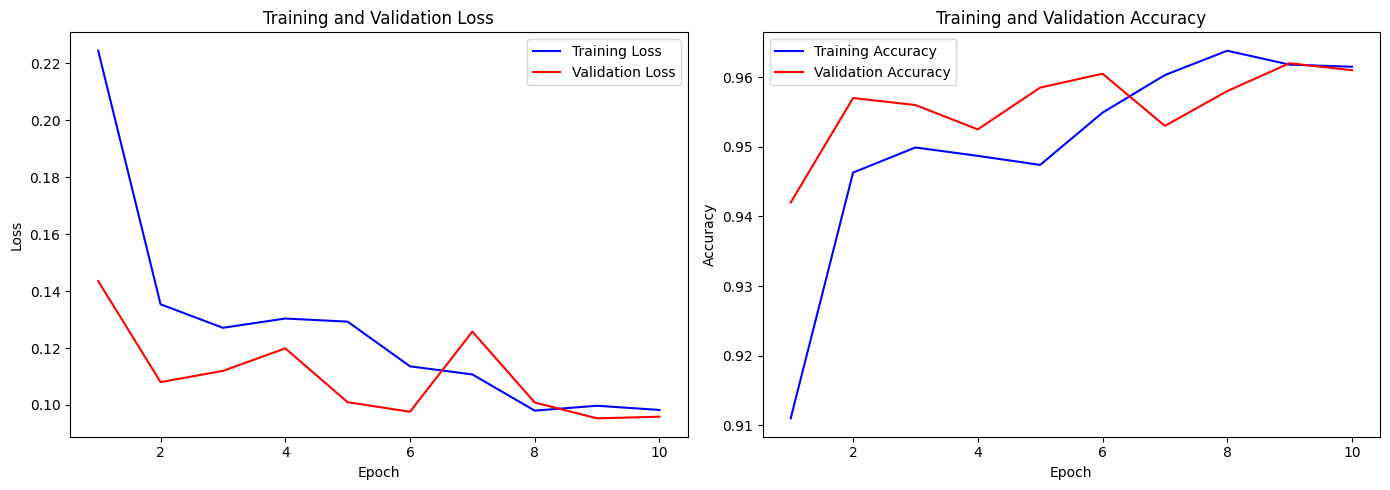

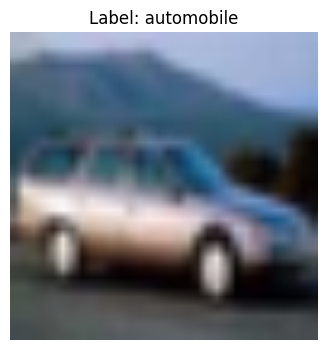

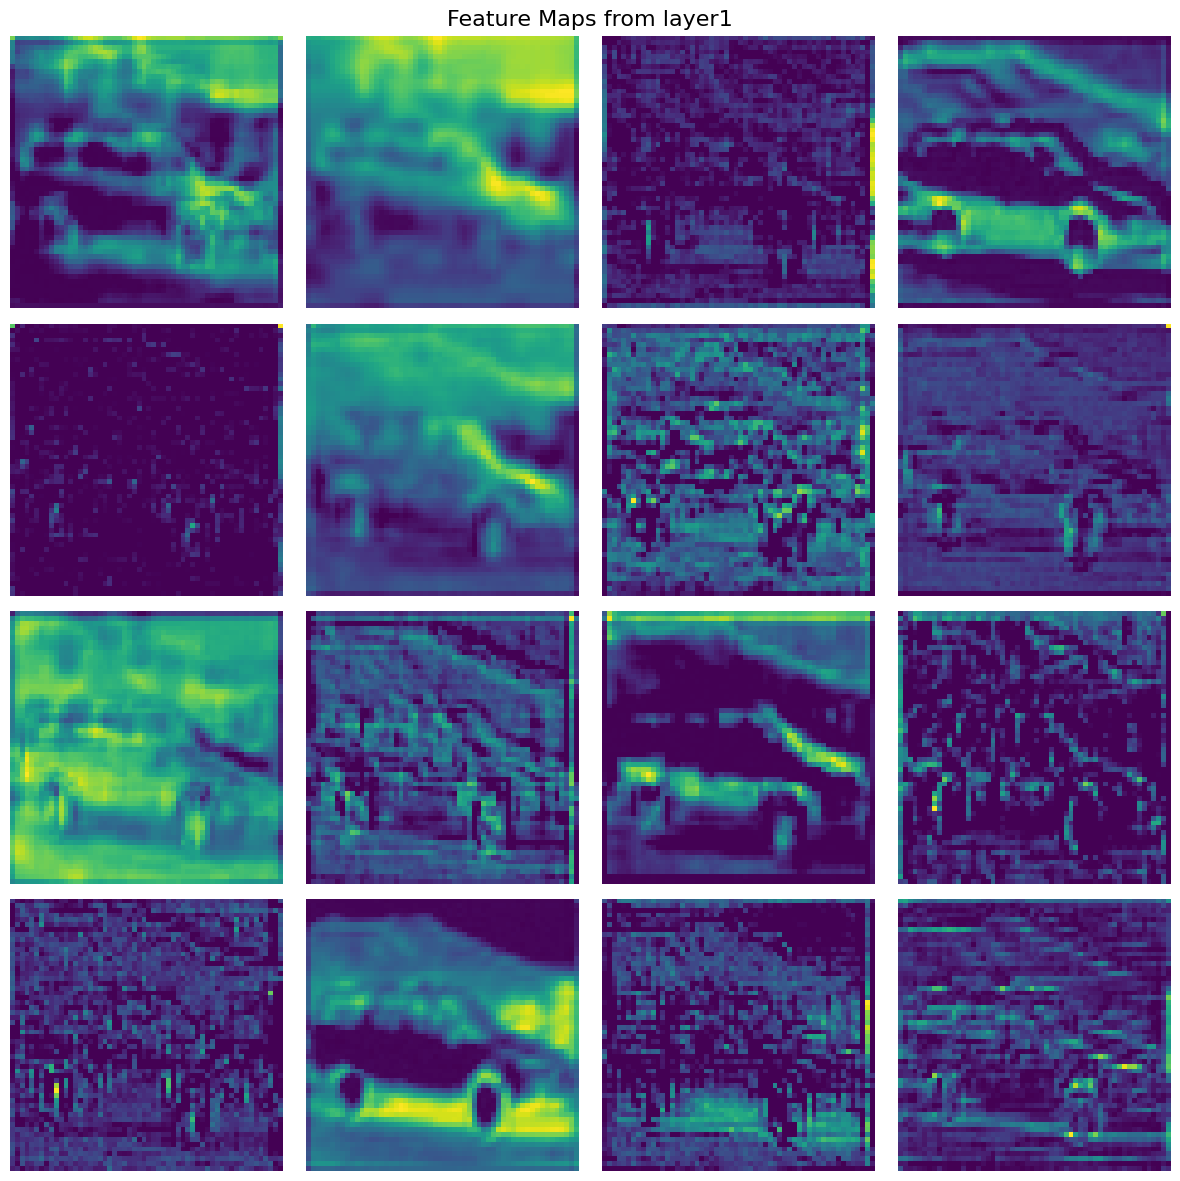

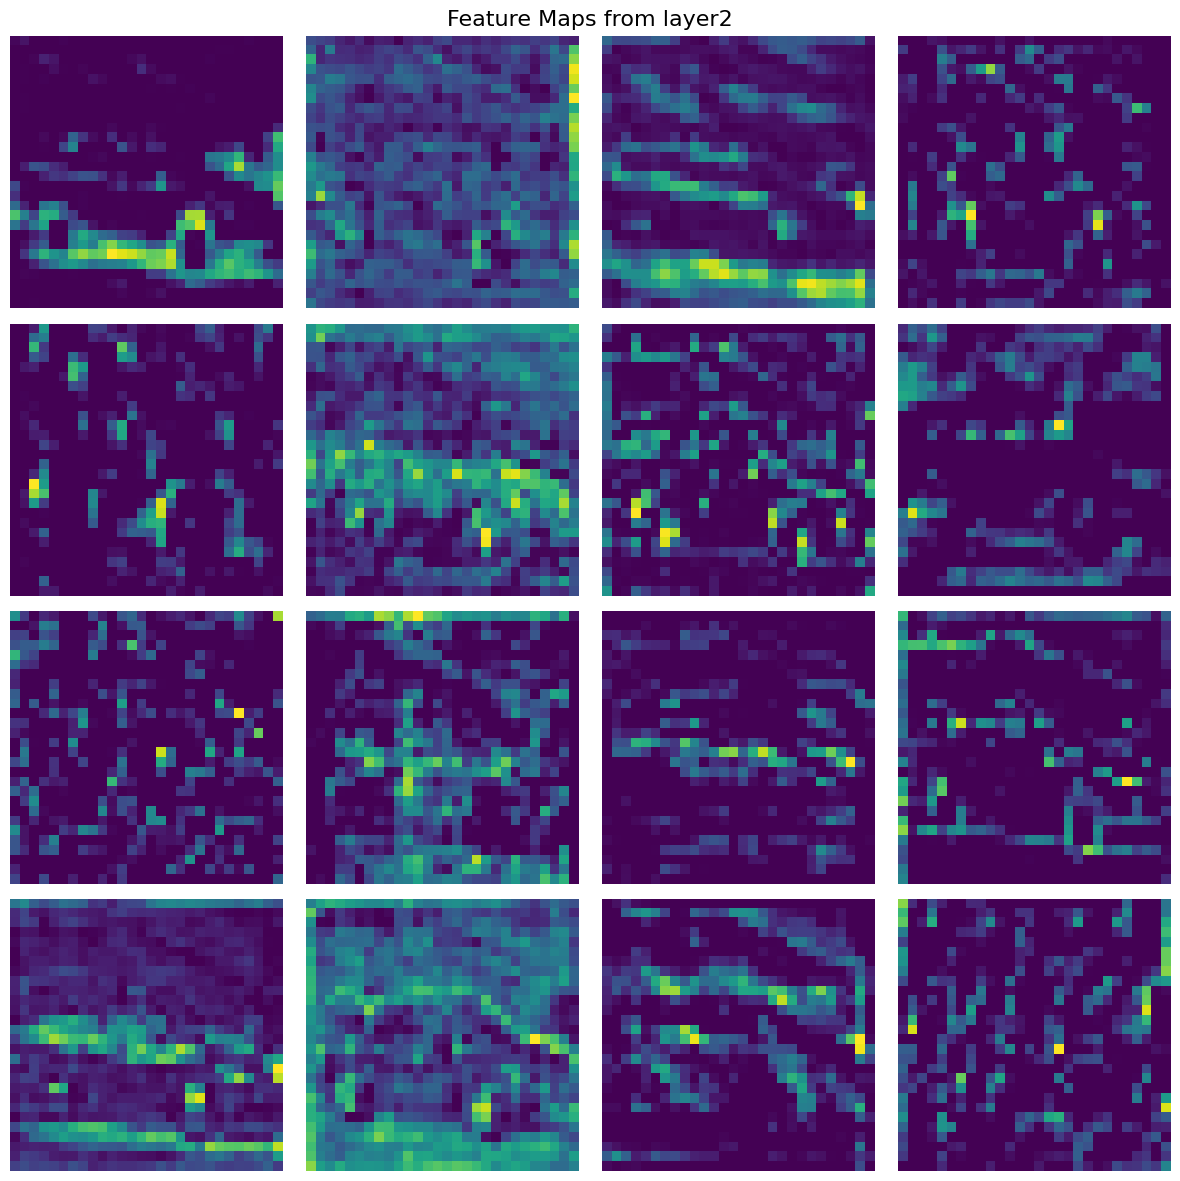

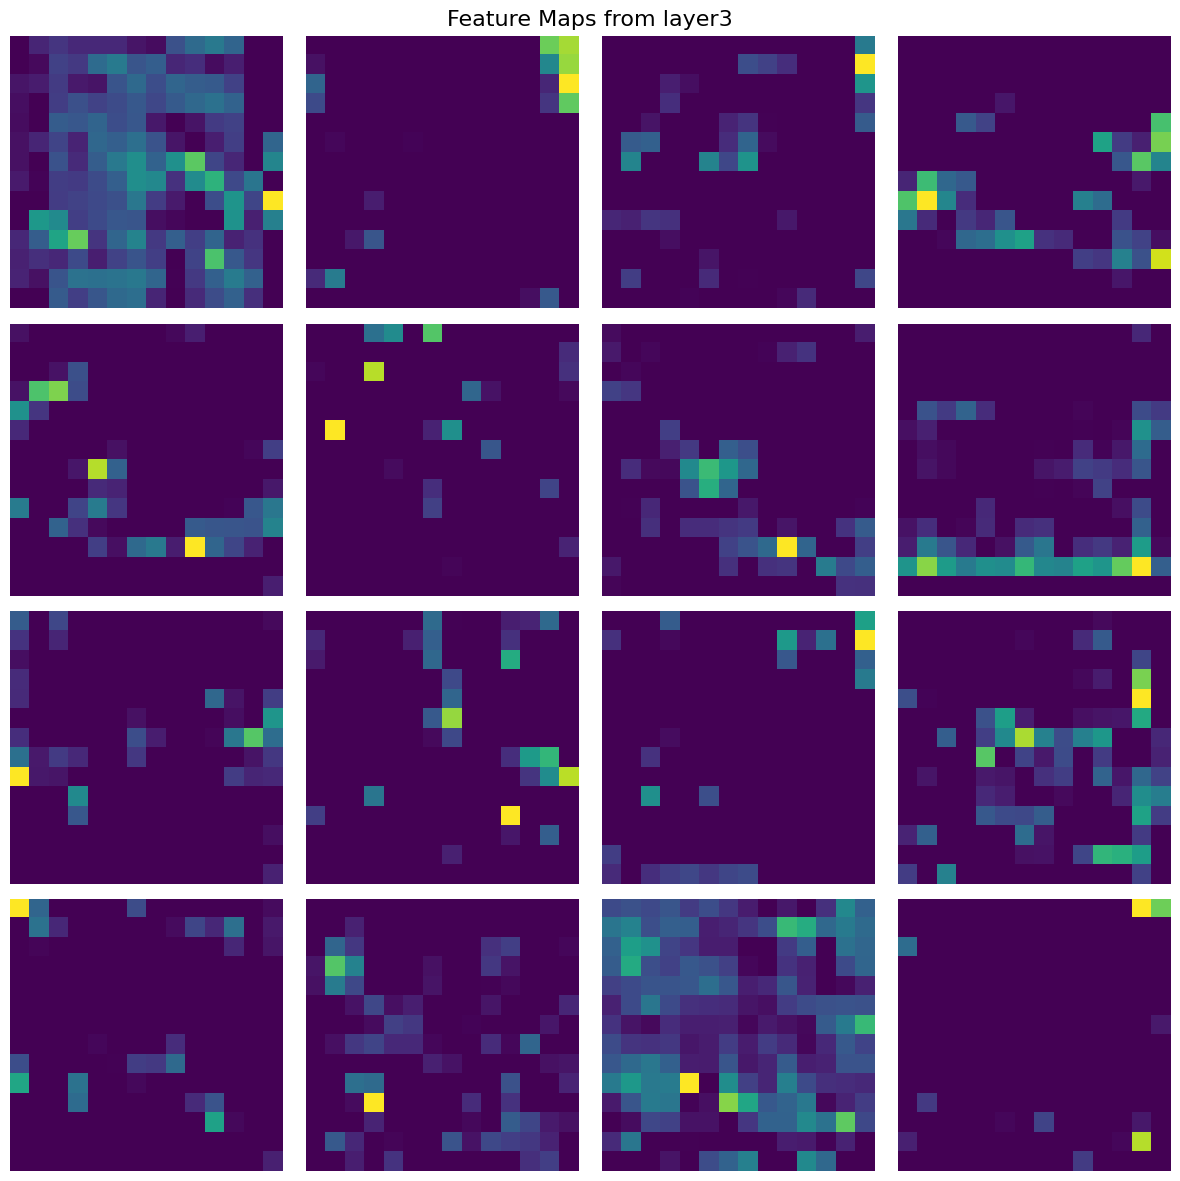

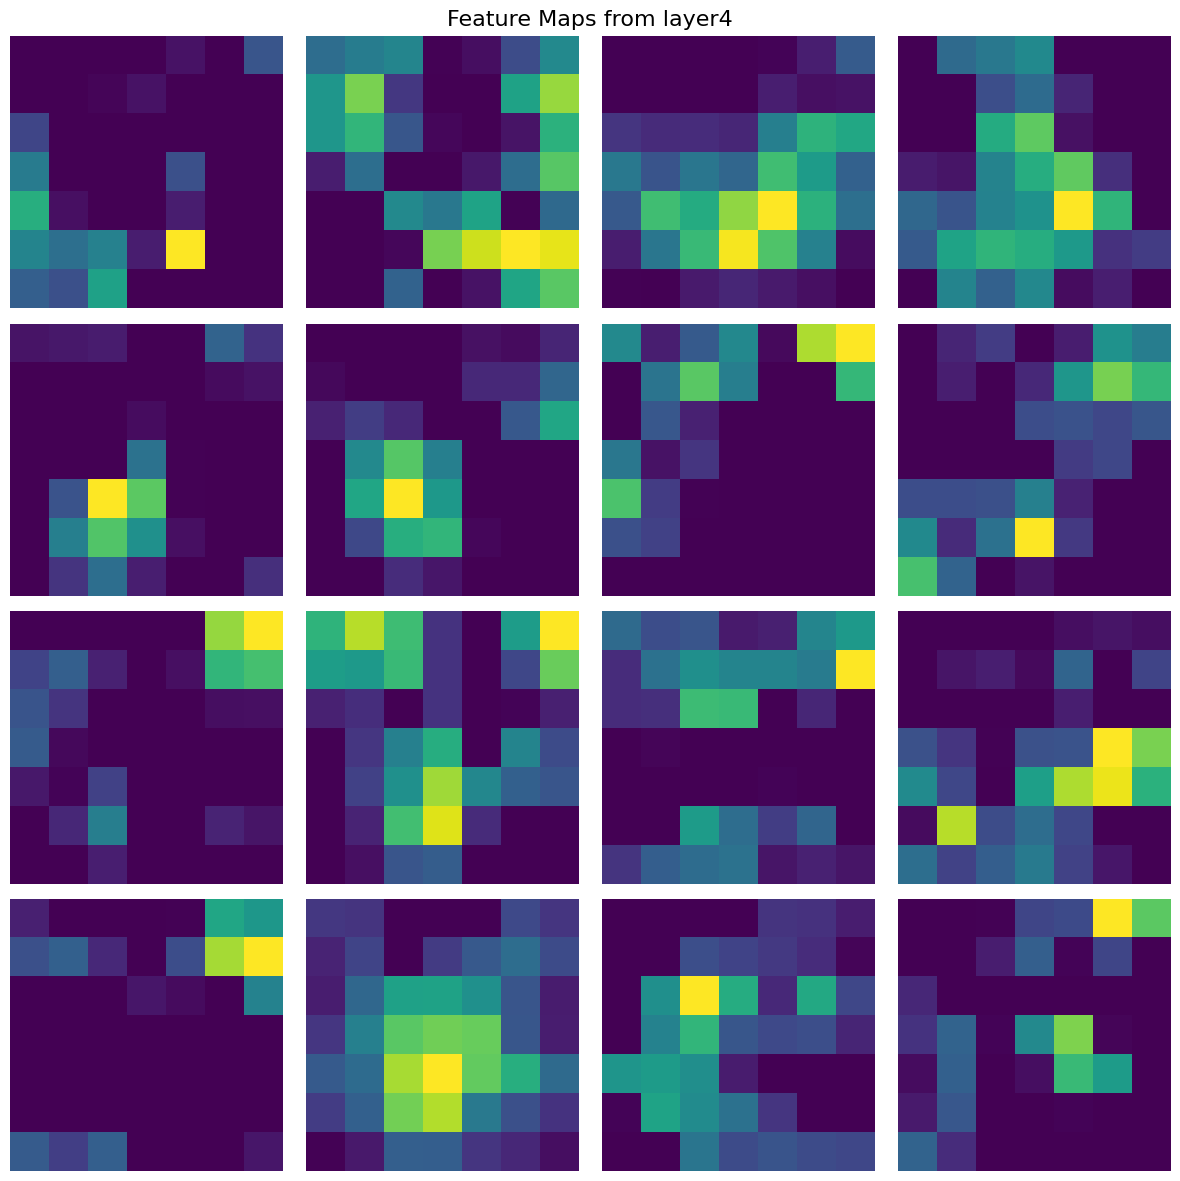

In [1]:
# CIFAR-10 Binary Classifier: Airplane vs. Automobile
# This script trains a binary classifier using a pre-trained ResNet-50 model on the CIFAR-10 dataset.
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
import time
import copy
import os
# Check if CUDA is available and set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Define transformations for the training and validation sets
transform = transforms.Compose([
    transforms.Resize(224),  # ResNet-50 expects 224x224 images
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # Mean for normalization
                         [0.229, 0.224, 0.225])  # Std for normalization
])

# Download and load the CIFAR-10 training and test datasets
data_dir = './data'

train_dataset = datasets.CIFAR10(root=data_dir, train=True,
                                 download=True, transform=transform)
test_dataset = datasets.CIFAR10(root=data_dir, train=False,
                                download=True, transform=transform)

# Function to filter the dataset for classes 'airplane' and 'automobile'
def filter_classes(dataset, classes=[0, 1]):
    """
    Filters the dataset to include only specified classes.

    Args:
        dataset: The dataset to filter.
        classes: List of class indices to include.

    Returns:
        Filtered dataset.
    """
    mask = np.isin(dataset.targets, classes)
    dataset.data = dataset.data[mask]
    dataset.targets = np.array(dataset.targets)[mask]
    return dataset

# Apply the filter to both training and test datasets
train_dataset = filter_classes(train_dataset, classes=[0, 1])
test_dataset = filter_classes(test_dataset, classes=[0, 1])

# Convert targets to torch tensors
train_dataset.targets = torch.tensor(train_dataset.targets)
test_dataset.targets = torch.tensor(test_dataset.targets)

# Create data loaders
batch_size = 32

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

# Define class names
class_names = ['airplane', 'automobile']

# Load the pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)

# Freeze all layers in the model
for param in model.parameters():
    param.requires_grad = False

# Modify the final fully connected layer to output 2 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Two classes: airplane and automobile

# Move the model to the selected device
model = model.to(device)

# Define the loss criterion and optimizer
criterion = nn.CrossEntropyLoss()

# Only the parameters of the final layer are being optimized
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Define a learning rate scheduler (optional)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Function to train and validate the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    """
    Trains and validates the model.

    Args:
        model: The neural network model.
        criterion: Loss function.
        optimizer: Optimization algorithm.
        scheduler: Learning rate scheduler.
        num_epochs: Number of epochs to train.

    Returns:
        Trained model and training history.
    """
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Lists to store loss and accuracy
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = test_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass and optimize only in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Store loss and accuracy
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.item())

                # Deep copy the model if it has better accuracy
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {int(time_elapsed // 60)}m {int(time_elapsed % 60)}s')
    print(f'Best Validation Accuracy: {best_acc:.4f}')

    # Load the best model weights
    model.load_state_dict(best_model_wts)

    history = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_acc': train_accuracies,
        'val_acc': val_accuracies
    }

    return model, history

# Function to evaluate the model on the test set
def evaluate_model(model, dataloader):
    """
    Evaluates the model on the test set and prints the accuracy.

    Args:
        model: The trained model.
        dataloader: DataLoader for the test set.
    """
    model.eval()  # Set model to evaluation mode
    running_corrects = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            running_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)

    test_accuracy = running_corrects.double() / total
    print(f'\nFinal Test Accuracy: {test_accuracy:.4f}')

# Train the model
num_epochs = 10  # You can adjust the number of epochs
model, history = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=num_epochs)

# Evaluate the model on the test set after training
evaluate_model(model, test_loader)

# Function to plot training and validation loss and accuracy
def plot_history(history, num_epochs):
    """
    Plots the training and validation loss and accuracy.

    Args:
        history: Dictionary containing loss and accuracy history.
        num_epochs: Number of epochs.
    """
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(14, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_history(history, num_epochs)

# Function to visualize feature maps
def visualize_feature_maps(model, layer_names, input_image, class_names):
    """
    Extracts and visualizes feature maps from specified layers.

    Args:
        model: The trained model.
        layer_names: List of layer names to extract feature maps from.
        input_image: A single input image tensor.
        class_names: List of class names.
    """
    feature_maps = {}
    input_image = input_image.unsqueeze(0).to(device)  # Add batch dimension

    # Function to create a hook
    def get_hook(name):
        def hook(module, input, output):
            feature_maps[name] = output.cpu().detach()
        return hook

    # Register hooks to the specified layers
    hooks = []
    for name, layer in model.named_modules():
        if name in layer_names:
            hooks.append(layer.register_forward_hook(get_hook(name)))

    # Forward pass to trigger hooks
    model(input_image)

    # Remove hooks
    for hook in hooks:
        hook.remove()

    # Plot the feature maps
    for layer_name, fmap in feature_maps.items():
        num_feature = fmap.shape[1]
        size = fmap.shape[2]
        # Determine grid size
        grid_size = int(np.ceil(np.sqrt(min(num_feature, 16))))
        plt.figure(figsize=(12, 12))
        plt.suptitle(f'Feature Maps from {layer_name}', fontsize=16)
        for i in range(min(num_feature, 16)):
            plt.subplot(grid_size, grid_size, i+1)
            plt.imshow(fmap[0, i, :, :], cmap='viridis')
            plt.axis('off')
        plt.tight_layout()
        plt.show()

# Select a sample image from the training set
sample_idx = 0  # Change this index to visualize different images
sample_img, sample_label = train_dataset[sample_idx]

# Function to unnormalize and display the image
def imshow(img, title):
    """
    Displays an image after unnormalizing.

    Args:
        img: Image tensor.
        title: Title for the plot.
    """
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Display the sample image
imshow(sample_img, f'Label: {class_names[sample_label]}')

# Define layers to extract feature maps from
layers_to_visualize = ['layer1', 'layer2', 'layer3', 'layer4']

# Visualize feature maps
visualize_feature_maps(model, layers_to_visualize, sample_img, class_names) 


Using device: cuda:0
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10
----------
Loss: 0.1942
Epoch 2/10
----------
Loss: 0.0515
Epoch 3/10
----------
Loss: 0.0283
Epoch 4/10
----------
Loss: 0.0224
Epoch 5/10
----------
Loss: 0.0138
Epoch 6/10
----------
Loss: 0.0177
Epoch 7/10
----------
Loss: 0.0101
Epoch 8/10
----------
Loss: 0.0099
Epoch 9/10
----------
Loss: 0.0047
Epoch 10/10
----------
Loss: 0.0047
Triplet Training complete in 27m 3s
Epoch 1/10
----------
Train Loss: 0.0187 Acc: 0.9938
Val Loss: 0.0084 Acc: 0.9970

Epoch 2/10
----------
Train Loss: 0.0038 Acc: 0.9994
Val Loss: 0.0080 Acc: 0.9975

Epoch 3/10
----------
Train Loss: 0.0027 Acc: 0.9993
Val Loss: 0.0077 Acc: 0.9975

Epoch 4/10
----------
Train Loss: 0.0035 Acc: 0.9991
Val Loss: 0.0076 Acc: 0.9975

Epoch 5/10
----------
Train Loss: 0.0032 Acc: 0.9989
Val Loss: 0.0091 Acc: 0.9970

Epoch 6/10
----------
Train Loss: 0.0030 Acc: 0.9992
Val Loss: 0.0084 Acc: 0.9965

Epoch 7/10
-------

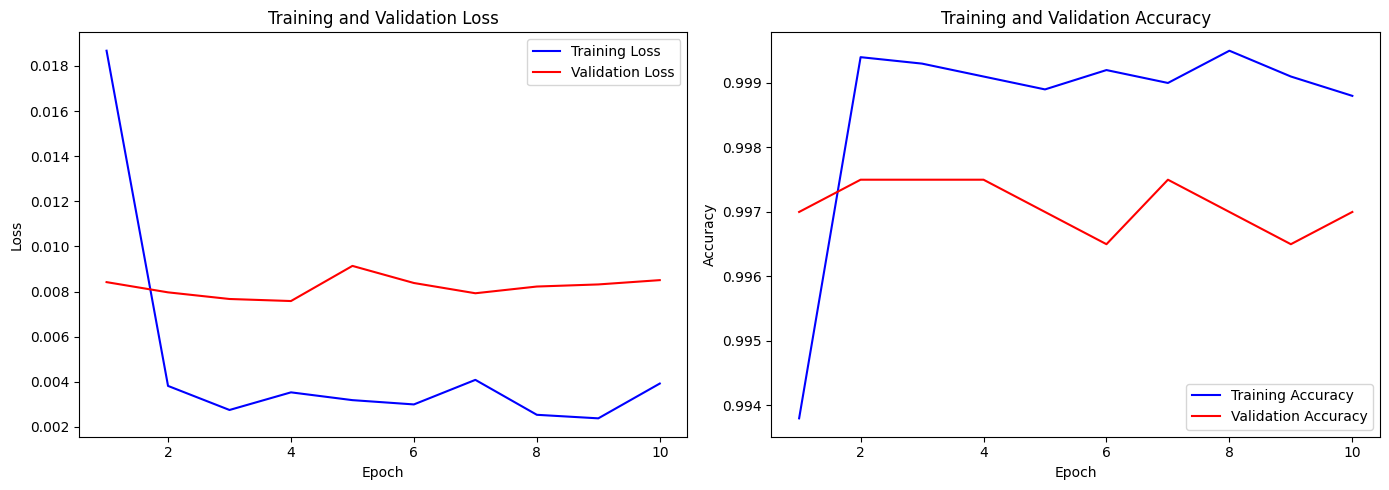

Test Accuracy: 0.9975


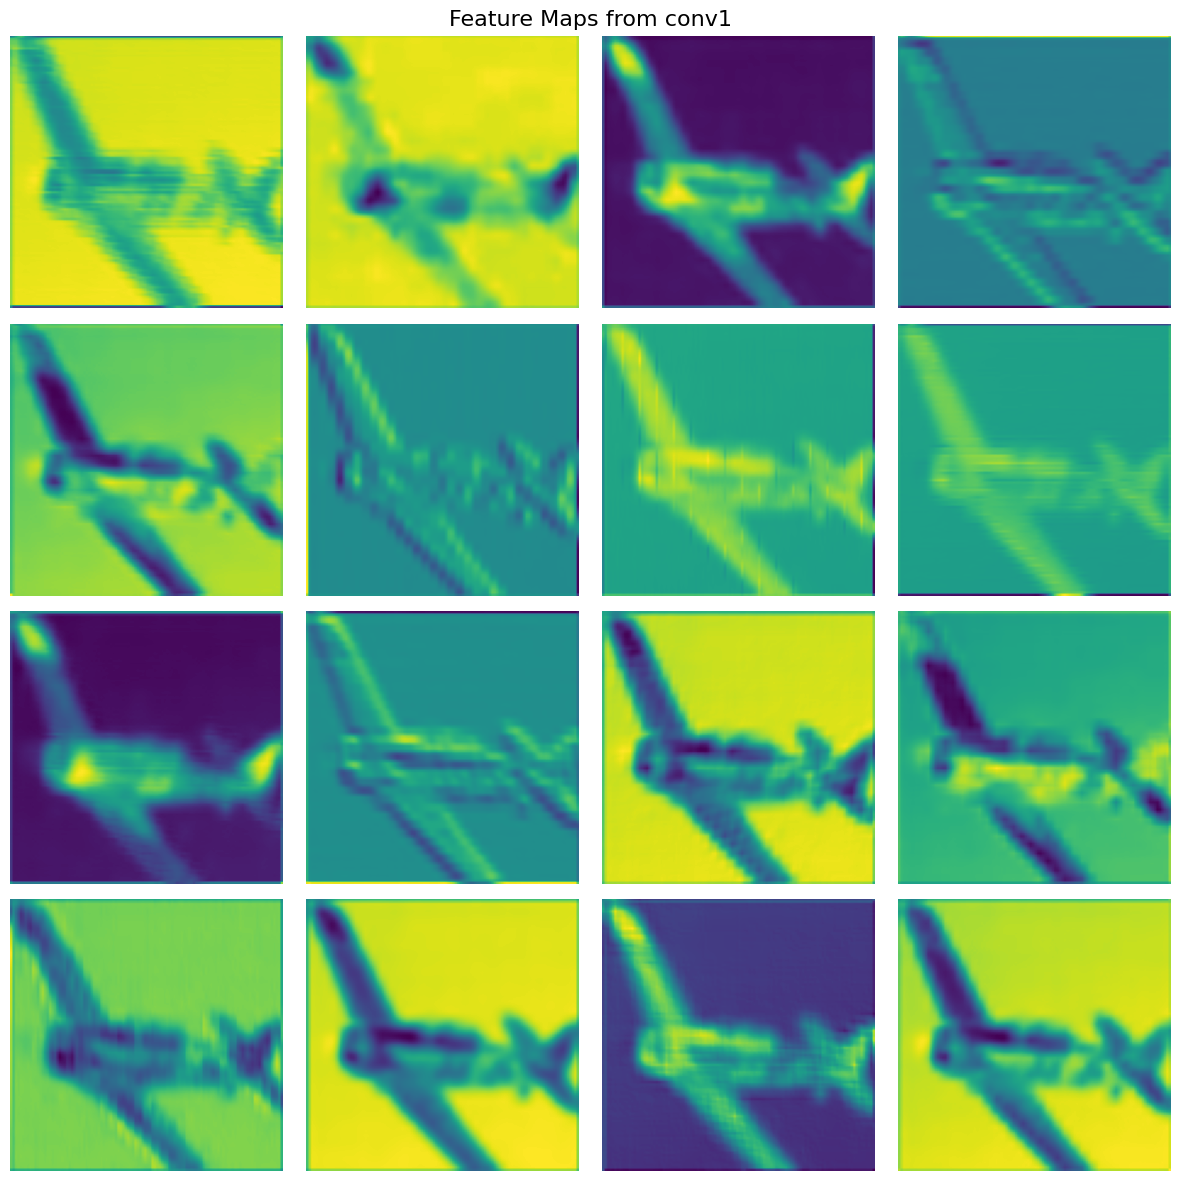

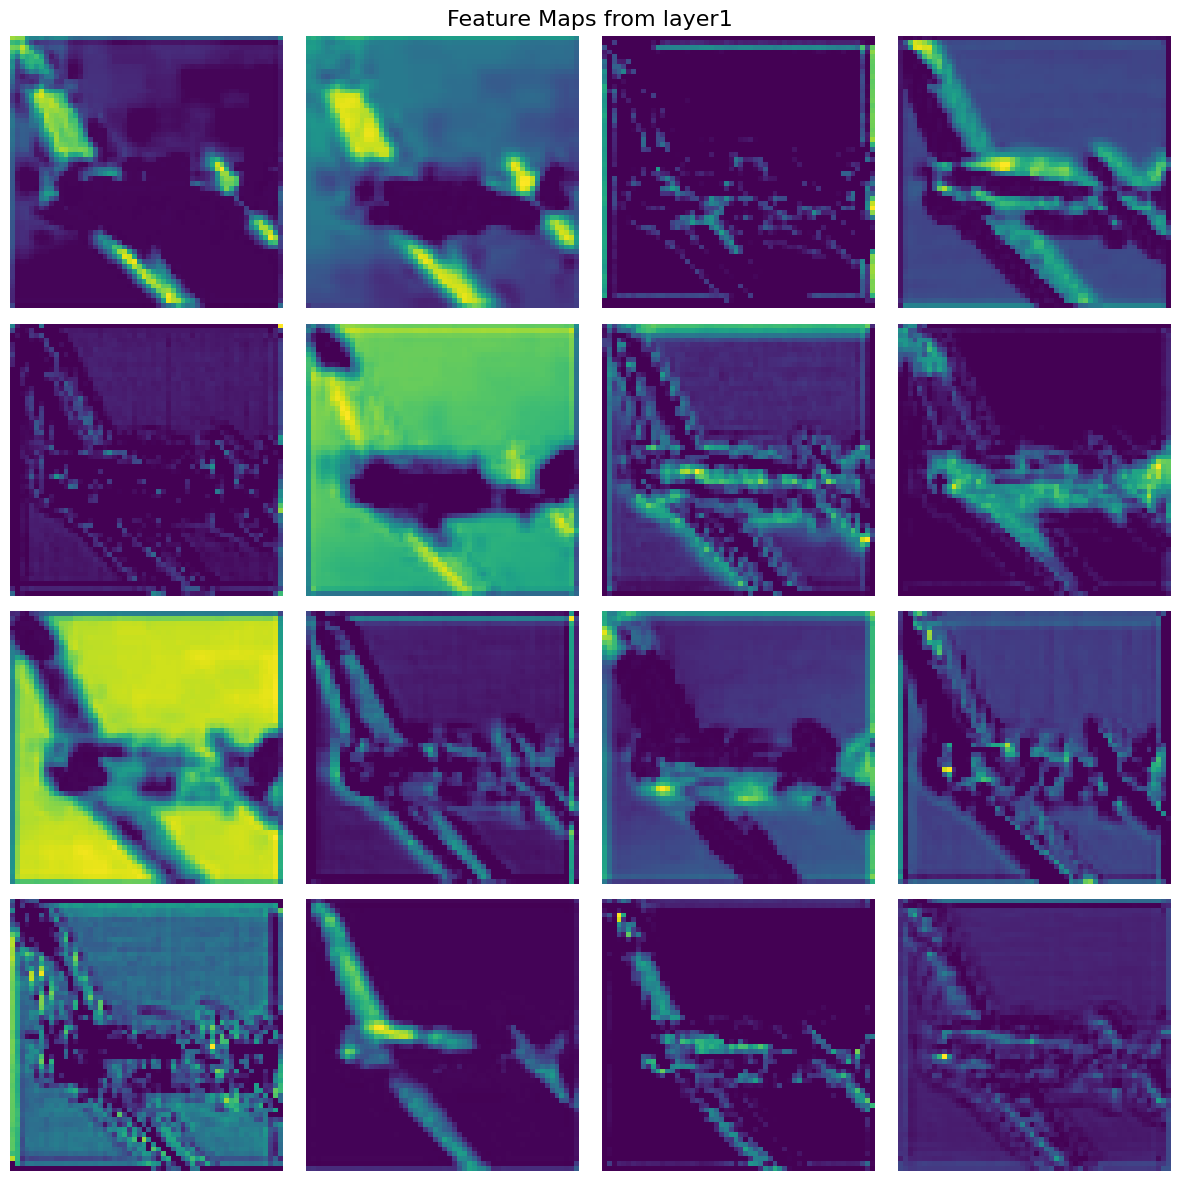

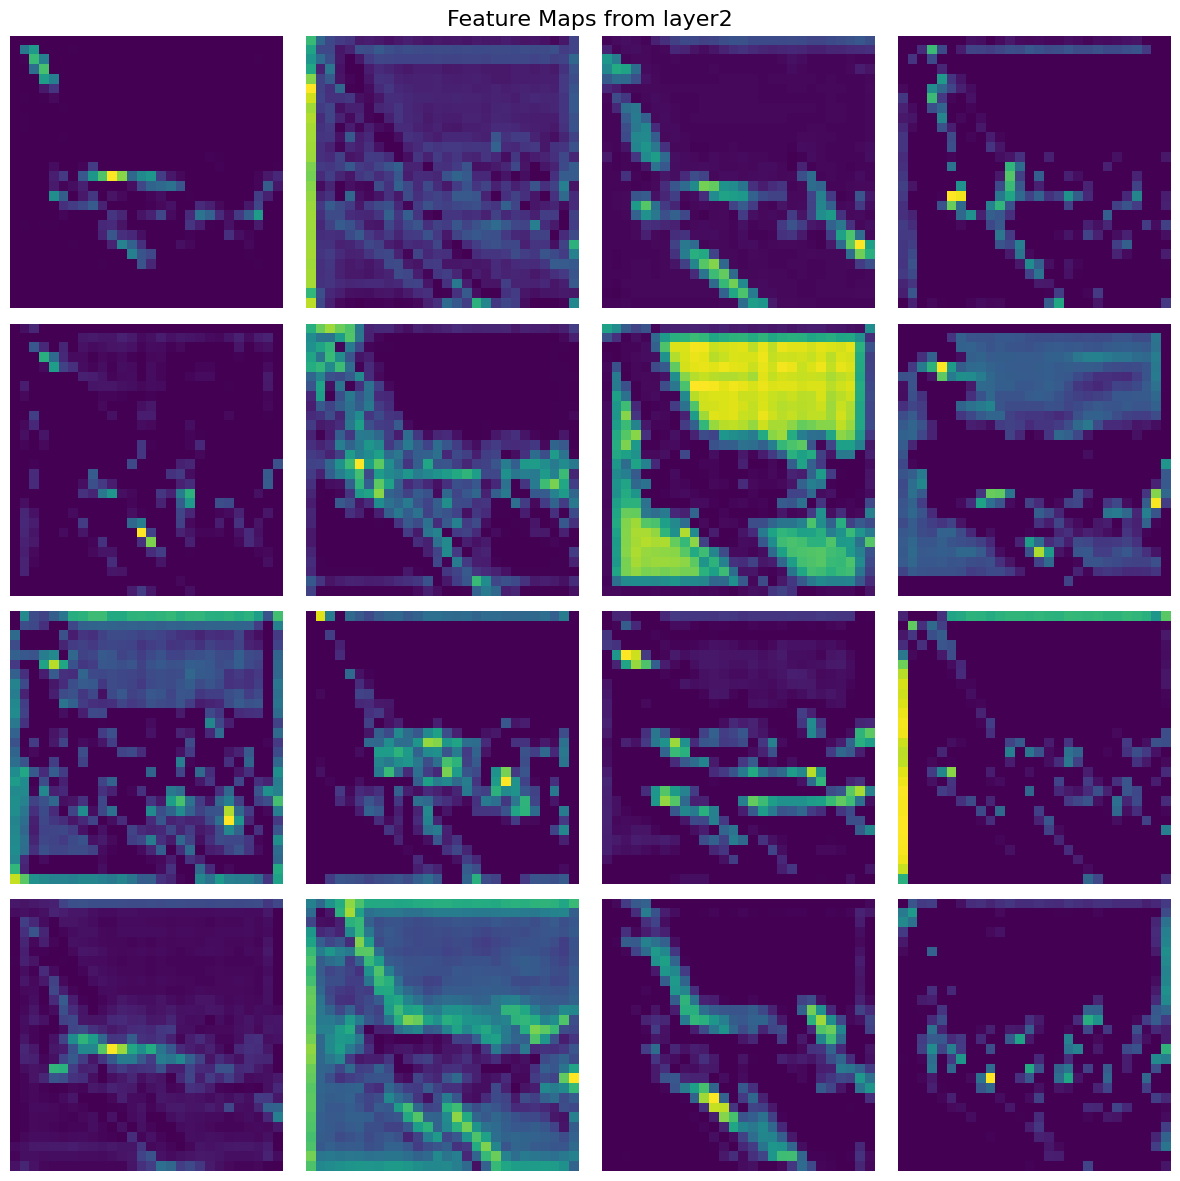

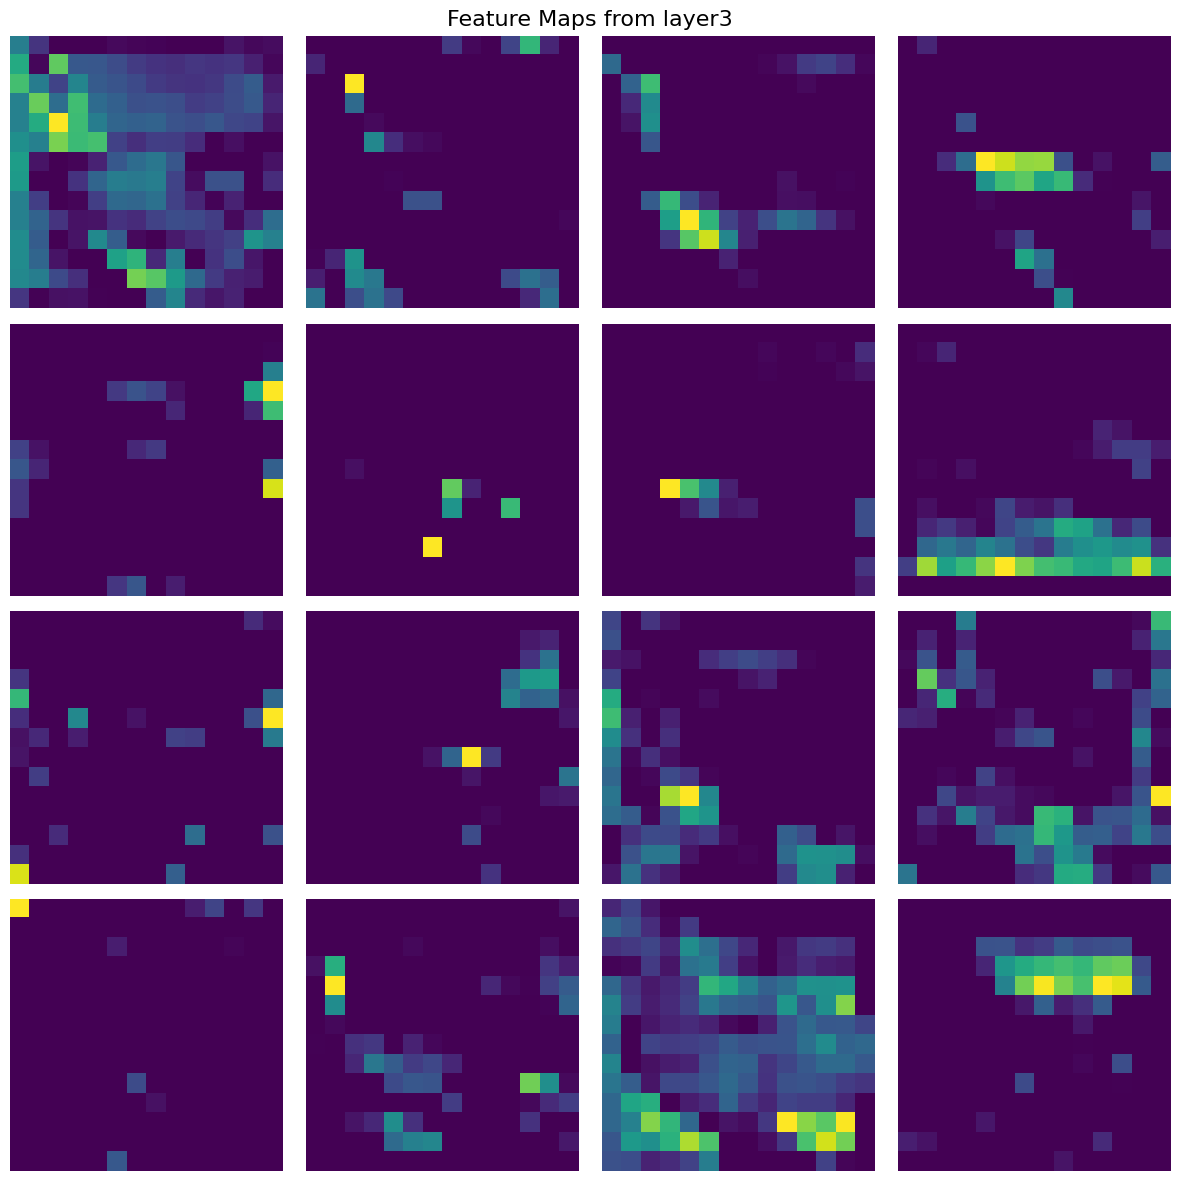

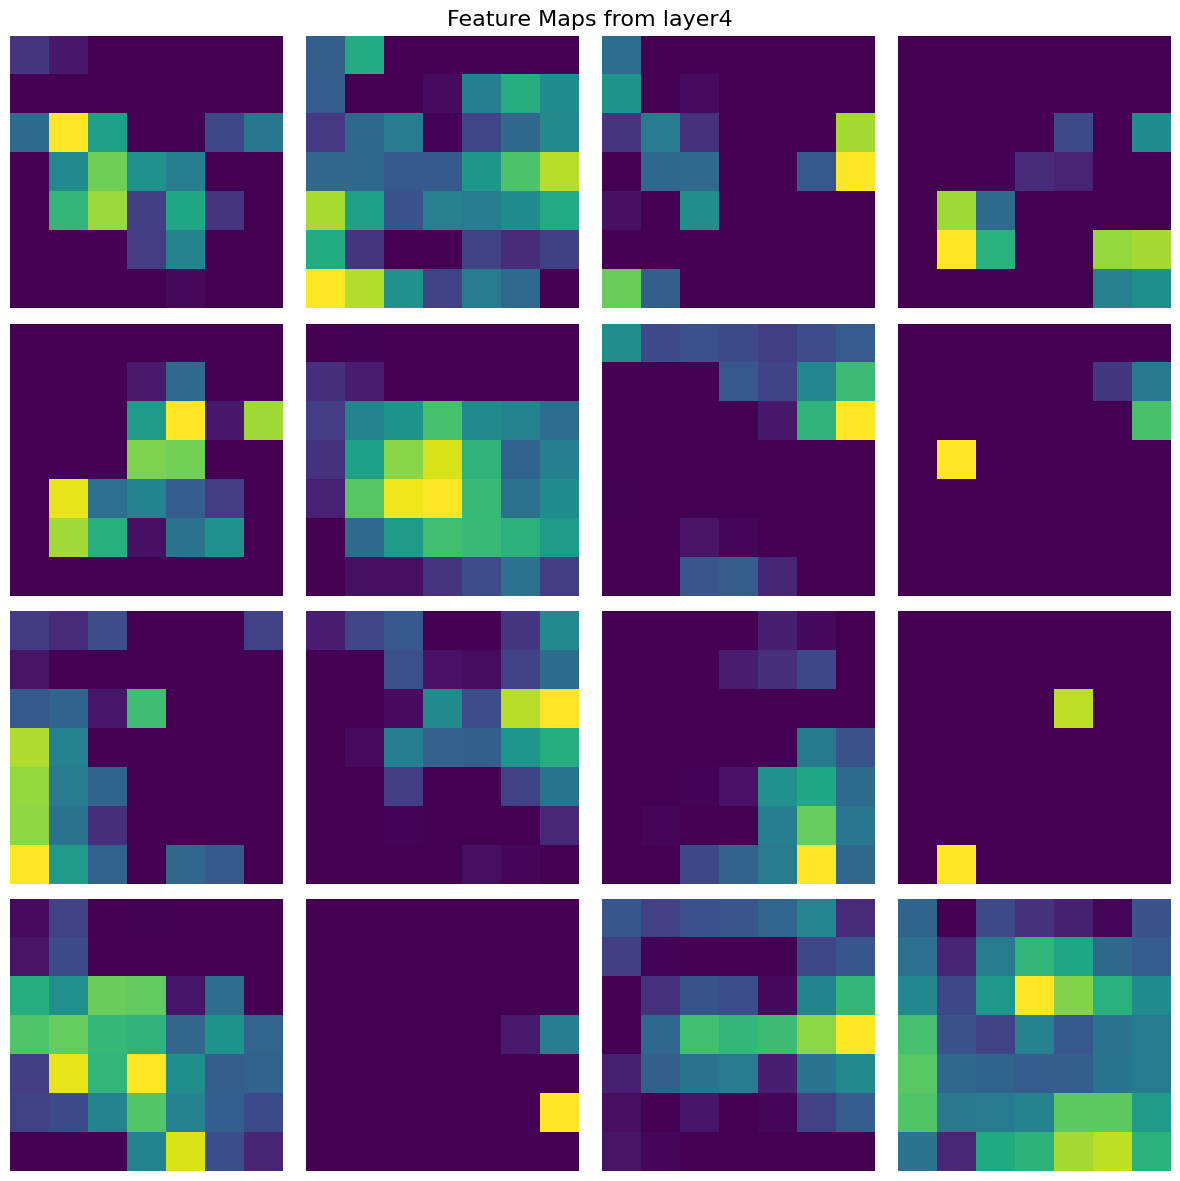

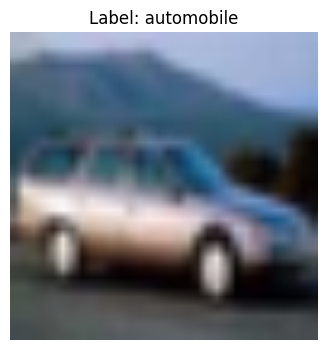

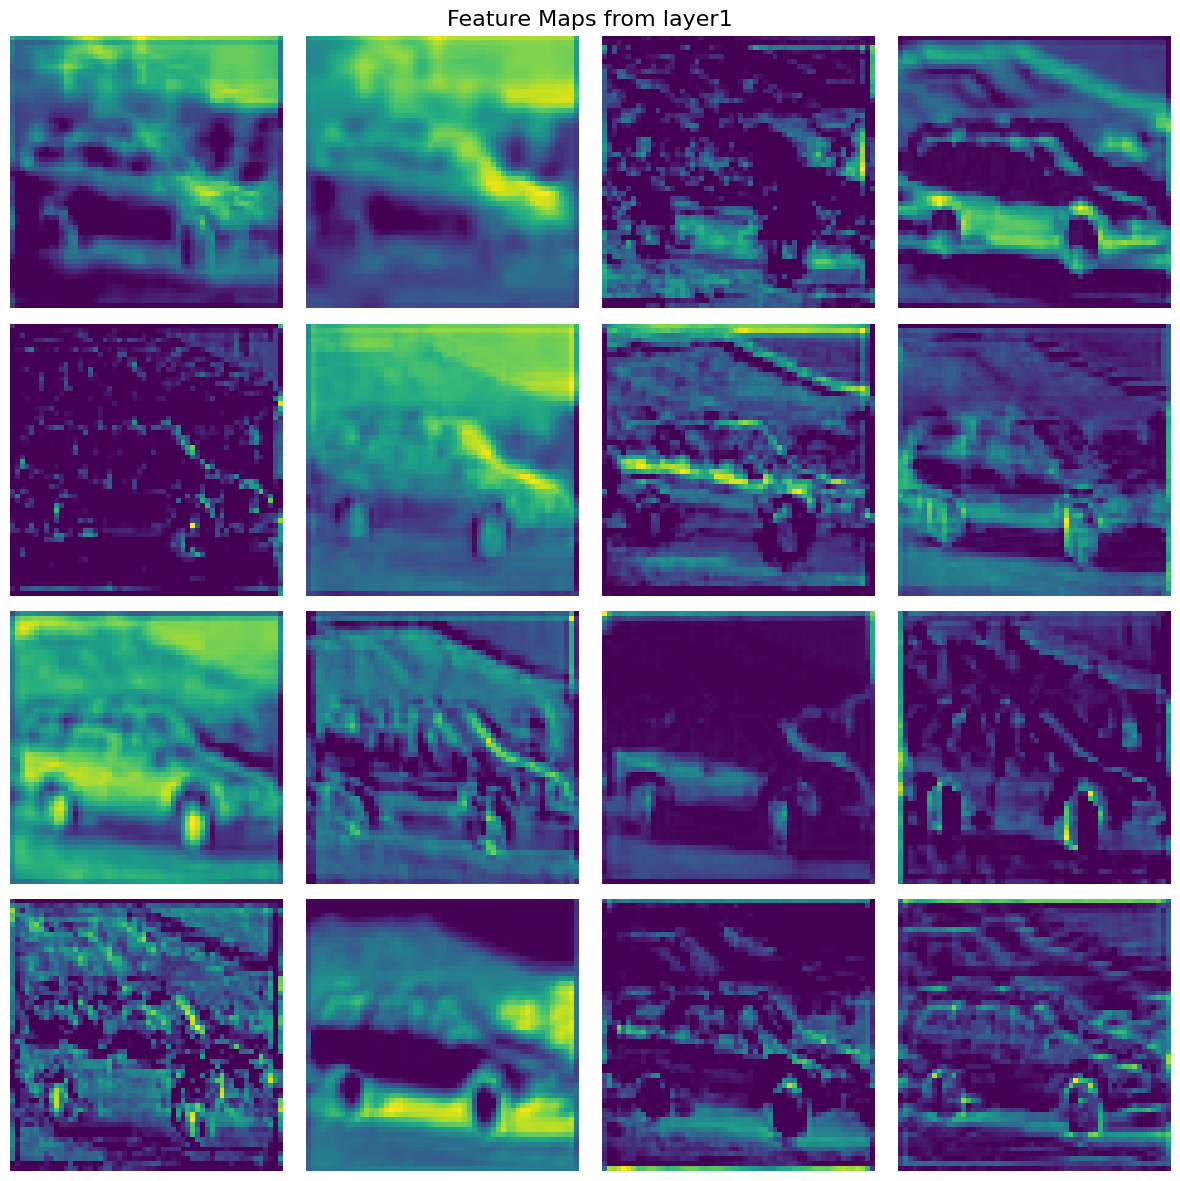

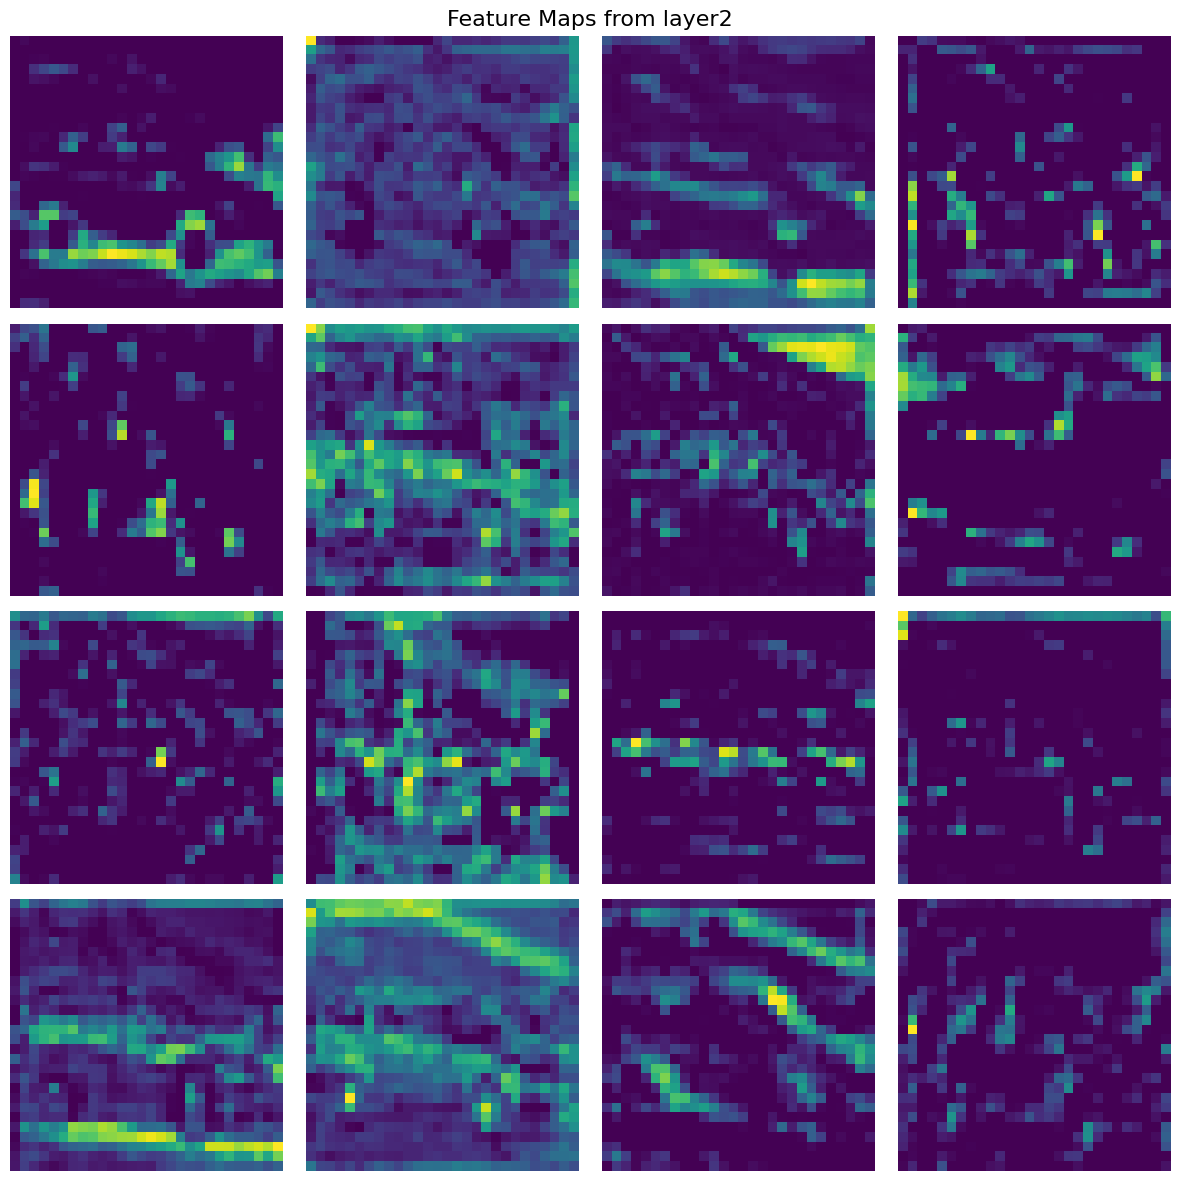

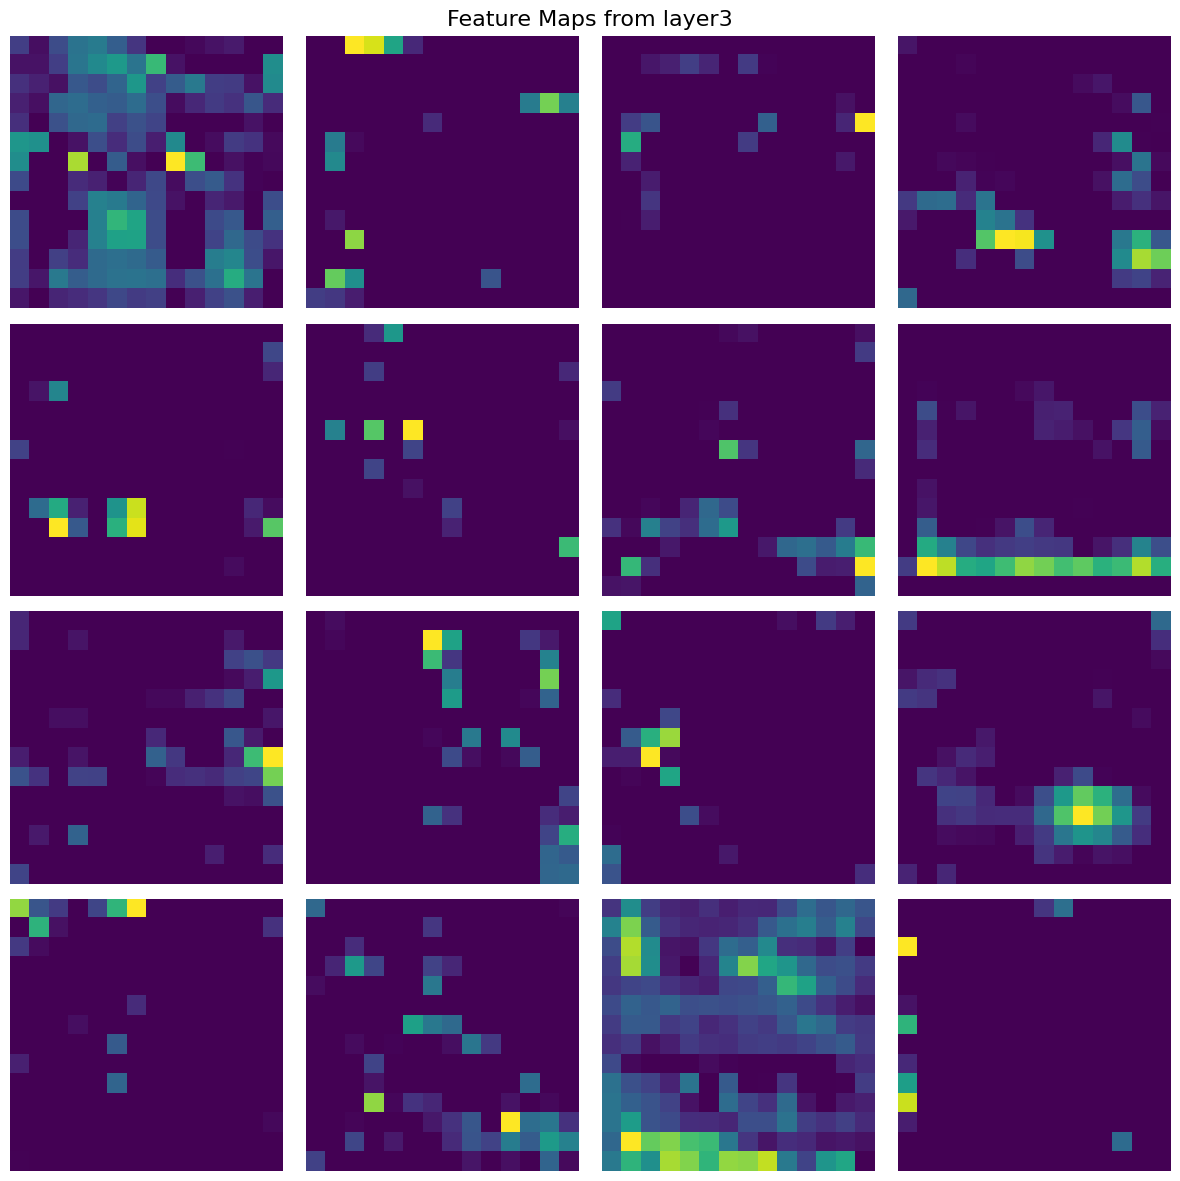

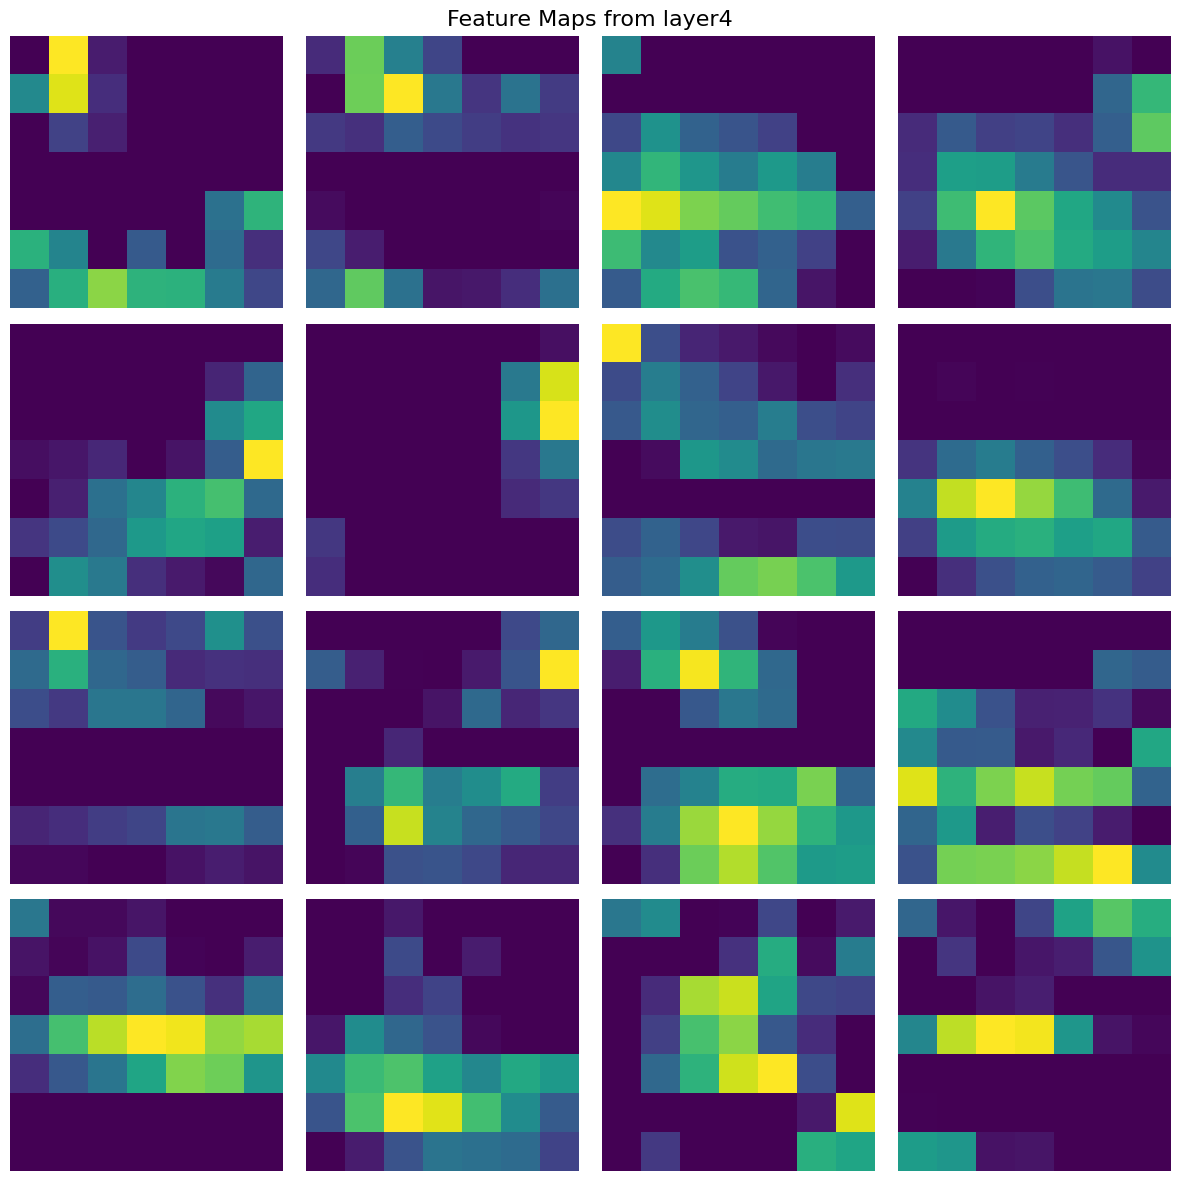

In [2]:
# CIFAR-10 Binary Classifier: Airplane vs. Automobile with Triplet Pretraining
# This script combines triplet loss pretraining and standard classification using ResNet-50.
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import time
import copy
import os

# -------------------------------
# Utility Functions
# -------------------------------

def get_activation(name):
    """Returns a hook function to capture activations."""
    def hook(model, input, output):
        activation[name] = output
    return hook

def visualize_feature_maps(activation, layer_name, num_feature_maps=16):
    """Visualizes feature maps from a specified layer."""
    fmap = activation[layer_name]
    num_feature = fmap.shape[1]
    size = fmap.shape[2]
    # Determine grid size
    grid_size = int(np.ceil(np.sqrt(min(num_feature, num_feature_maps))))
    plt.figure(figsize=(12, 12))
    plt.suptitle(f'Feature Maps from {layer_name}', fontsize=16)
    for i in range(min(num_feature, num_feature_maps)):
        plt.subplot(grid_size, grid_size, i+1)
        plt.imshow(fmap[0, i, :, :], cmap='viridis')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def imshow(img, title):
    """Displays an image after unnormalizing."""
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

# -------------------------------
# Device Configuration
# -------------------------------
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# -------------------------------
# Data Transformations
# -------------------------------
transform = transforms.Compose([
    transforms.Resize(224),  # ResNet-50 expects 224x224 images
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # Mean for normalization
                         [0.229, 0.224, 0.225])  # Std for normalization
])

# -------------------------------
# Download and Load CIFAR-10 Dataset
# -------------------------------
data_dir = './data'

train_dataset_full = datasets.CIFAR10(root=data_dir, train=True,
                                     download=True, transform=transform)
test_dataset_full = datasets.CIFAR10(root=data_dir, train=False,
                                    download=True, transform=transform)

# -------------------------------
# Filter Dataset for Classes 'Airplane' and 'Automobile'
# -------------------------------
def filter_classes(dataset, classes=[0, 1]):
    """
    Filters the dataset to include only specified classes.

    Args:
        dataset: The dataset to filter.
        classes: List of class indices to include.

    Returns:
        Filtered dataset.
    """
    mask = np.isin(dataset.targets, classes)
    dataset.data = dataset.data[mask]
    dataset.targets = np.array(dataset.targets)[mask]
    return dataset

# Apply the filter to both training and test datasets
train_dataset_full = filter_classes(train_dataset_full, classes=[0, 1])
test_dataset_full = filter_classes(test_dataset_full, classes=[0, 1])

# Convert targets to torch tensors
train_dataset_full.targets = torch.tensor(train_dataset_full.targets)
test_dataset_full.targets = torch.tensor(test_dataset_full.targets)

# Define class names
class_names = ['airplane', 'automobile']

# -------------------------------
# Triplet Dataset Class
# -------------------------------
class TripletCIFAR10(Dataset):
    def __init__(self, dataset, classes_to_include, transform=None):
        self.transform = transform
        self.classes_to_include = classes_to_include

        # Prepare data and targets
        self.data = []
        self.targets = []

        for idx in range(len(dataset)):
            img, label = dataset.data[idx], dataset.targets[idx].item()
            if label in classes_to_include:
                self.data.append(img)
                self.targets.append(classes_to_include.index(label))  # Remap labels to 0 and 1

        self.data = np.array(self.data)
        self.targets = np.array(self.targets)

        # Build a dictionary to map labels to indices
        self.label_to_indices = {label: np.where(self.targets == label)[0]
                                 for label in set(self.targets)}

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        anchor_img = self.data[idx]
        anchor_label = self.targets[idx]

        # Select a positive sample
        positive_idx = idx
        while positive_idx == idx:
            positive_idx = np.random.choice(self.label_to_indices[anchor_label])
        positive_img = self.data[positive_idx]

        # Select a negative sample
        negative_label = (anchor_label + 1) % 2  # Since we have only 2 classes
        negative_idx = np.random.choice(self.label_to_indices[negative_label])
        negative_img = self.data[negative_idx]

        # Transform images
        anchor_img = Image.fromarray(anchor_img)
        positive_img = Image.fromarray(positive_img)
        negative_img = Image.fromarray(negative_img)

        if self.transform:
            anchor_img = self.transform(anchor_img)
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)

        return (anchor_img, positive_img, negative_img), []

# -------------------------------
# Create Triplet Dataset and DataLoader
# -------------------------------
batch_size_triplet = 32

train_dataset_triplet = TripletCIFAR10(train_dataset_full, classes_to_include=[0, 1], transform=transform)
train_loader_triplet = DataLoader(train_dataset_triplet, batch_size=batch_size_triplet, shuffle=True, num_workers=2)

# -------------------------------
# Feature Extractor Model with Triplet Loss
# -------------------------------
class ResNet50Triplet(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNet50Triplet, self).__init__()
        self.model = models.resnet50(pretrained=pretrained)
        self.model.fc = nn.Identity()  # Remove the last fully connected layer

    def forward(self, x):
        x = self.model(x)
        return x

# Instantiate the triplet model
model_triplet = ResNet50Triplet(pretrained=True)
model_triplet = model_triplet.to(device)

# Define triplet loss and optimizer
triplet_criterion = nn.TripletMarginLoss(margin=1.0, p=2)
optimizer_triplet = optim.SGD(model_triplet.parameters(), lr=0.001, momentum=0.9)

# -------------------------------
# Train Triplet Model
# -------------------------------
def train_triplet_model(model, dataloader, criterion, optimizer, num_epochs=10):
    """
    Trains the model using triplet loss.

    Args:
        model: The neural network model.
        dataloader: DataLoader for triplet data.
        criterion: Triplet loss function.
        optimizer: Optimization algorithm.
        num_epochs: Number of epochs to train.

    Returns:
        Trained model and list of training losses.
    """
    since = time.time()

    train_losses = []

    model.train()  # Set model to training mode

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        running_loss = 0.0

        # Iterate over data
        for data in dataloader:
            (anchor_img, positive_img, negative_img), _ = data
            anchor_img = anchor_img.to(device)
            positive_img = positive_img.to(device)
            negative_img = negative_img.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            anchor_output = model(anchor_img)
            positive_output = model(positive_img)
            negative_output = model(negative_img)

            loss = criterion(anchor_output, positive_output, negative_output)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * anchor_img.size(0)

        epoch_loss = running_loss / len(dataloader.dataset)
        train_losses.append(epoch_loss)

        print('Loss: {:.4f}'.format(epoch_loss))

    # Training complete
    time_elapsed = time.time() - since
    print('Triplet Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return model, train_losses

# Train the triplet model
num_epochs_triplet = 10
model_triplet, train_losses_triplet = train_triplet_model(
    model_triplet, train_loader_triplet, triplet_criterion, optimizer_triplet, num_epochs=num_epochs_triplet)

# -------------------------------
# Classifier Model
# -------------------------------
class ResNet50Classifier(nn.Module):
    def __init__(self, feature_extractor):
        super(ResNet50Classifier, self).__init__()
        self.feature_extractor = feature_extractor.model  # Include all layers except the final fc layer
        # Freeze the feature extractor
        for param in self.feature_extractor.parameters():
            param.requires_grad = False
        # Add a new fully connected layer
        self.fc = nn.Linear(2048, 2)  # Output size is 2 classes

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.fc(x)
        return x

# Instantiate the classifier model
model_classifier = ResNet50Classifier(model_triplet)
model_classifier = model_classifier.to(device)

# -------------------------------
# Define Loss Criterion and Optimizer for Classifier
# -------------------------------
criterion_classifier = nn.CrossEntropyLoss()
optimizer_classifier = optim.SGD(model_classifier.fc.parameters(), lr=0.001, momentum=0.9)

# Optional: Define a learning rate scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_classifier, step_size=7, gamma=0.1)

# -------------------------------
# Create Data Loaders for Classification
# -------------------------------
batch_size_classifier = 32

train_loader = DataLoader(train_dataset_full, batch_size=batch_size_classifier,
                          shuffle=True, num_workers=2)

test_loader = DataLoader(test_dataset_full, batch_size=batch_size_classifier,
                         shuffle=False, num_workers=2)

# -------------------------------
# Train and Validate Classifier
# -------------------------------
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=10):
    """
    Trains and validates the classifier model.

    Args:
        model: The classifier model.
        train_loader: DataLoader for training data.
        test_loader: DataLoader for validation data.
        criterion: Loss function.
        optimizer: Optimization algorithm.
        scheduler: Learning rate scheduler.
        num_epochs: Number of epochs to train.

    Returns:
        Trained model and training history.
    """
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Lists to store loss and accuracy
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = test_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass and optimize only in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Store loss and accuracy
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.item())

                # Deep copy the model if it has better accuracy
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Classifier Training complete in {int(time_elapsed // 60)}m {int(time_elapsed % 60)}s')
    print(f'Best Validation Accuracy: {best_acc:.4f}')

    # Load the best model weights
    model.load_state_dict(best_model_wts)

    history = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_acc': train_accuracies,
        'val_acc': val_accuracies
    }

    return model, history

# Train the classifier model
num_epochs_classifier = 10  # You can adjust the number of epochs
model_classifier, history_classifier = train_model(
    model_classifier, train_loader, test_loader, criterion_classifier, optimizer_classifier, exp_lr_scheduler, num_epochs=num_epochs_classifier)

# -------------------------------
# Plotting Training Histories
# -------------------------------
def plot_history(history, num_epochs):
    """
    Plots the training and validation loss and accuracy.

    Args:
        history: Dictionary containing loss and accuracy history.
        num_epochs: Number of epochs.
    """
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(14, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the classifier training history
plot_history(history_classifier, num_epochs_classifier)

# -------------------------------
# Evaluate Classifier on Test Set
# -------------------------------
def evaluate_model(model, dataloader):
    """
    Evaluates the model on the test set.

    Args:
        model: The trained classifier model.
        dataloader: DataLoader for test data.

    Returns:
        Accuracy of the model on the test set.
    """
    model.eval()
    running_corrects = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            running_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)

    accuracy = running_corrects.double() / total
    print('Test Accuracy: {:.4f}'.format(accuracy))
    return accuracy

test_accuracy = evaluate_model(model_classifier, test_loader)
# -------------------------------
# Visualize Feature Maps
# -------------------------------
activation = {}

def get_activation(name):
    """Returns a hook function to capture activations."""
    def hook(model, input, output):
        activation[name] = output.detach().cpu()  # Detach and move to CPU
    return hook

def visualize_feature_maps(activation, layer_name, num_feature_maps=16):
    """Visualizes feature maps from a specified layer."""
    fmap = activation[layer_name]
    num_feature = fmap.shape[1]
    
    # Determine grid size based on the number of feature maps to display
    grid_size = int(np.ceil(np.sqrt(min(num_feature, num_feature_maps))))
    
    plt.figure(figsize=(12, 12))
    plt.suptitle(f'Feature Maps from {layer_name}', fontsize=16)
    
    for i in range(min(num_feature, num_feature_maps)):
        plt.subplot(grid_size, grid_size, i + 1)
        feature_map = fmap[0, i, :, :].numpy()  # Convert tensor to NumPy array
        plt.imshow(feature_map, cmap='viridis')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Register hooks to the desired layers
model_classifier.feature_extractor.conv1.register_forward_hook(get_activation('conv1'))
model_classifier.feature_extractor.layer1.register_forward_hook(get_activation('layer1'))
model_classifier.feature_extractor.layer2.register_forward_hook(get_activation('layer2'))
model_classifier.feature_extractor.layer3.register_forward_hook(get_activation('layer3'))
model_classifier.feature_extractor.layer4.register_forward_hook(get_activation('layer4'))

# Function to visualize feature maps after forward pass
def visualize_all_feature_maps(model, dataloader, class_names, layers_to_visualize=['conv1', 'layer1', 'layer2', 'layer3', 'layer4']):
    """
    Visualizes feature maps from specified layers using a batch of data.

    Args:
        model: The trained classifier model.
        dataloader: DataLoader for training data.
        class_names: List of class names.
        layers_to_visualize: List of layer names to visualize.
    """
    # Get a batch of training data
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    inputs = images.to(device)

    # Forward pass through the model
    output = model(inputs)

    # Plot feature maps for the first image in the batch
    for layer in layers_to_visualize:
        if layer in activation:
            visualize_feature_maps(activation, layer)

# Visualize feature maps using a batch from the training loader
visualize_all_feature_maps(model_classifier, train_loader, class_names)

# -------------------------------
# Visualize a Sample Image and Its Feature Maps
# -------------------------------
# Select a sample image from the training set
sample_idx = 0  # Change this index to visualize different images
sample_img, sample_label = train_dataset_full[sample_idx]

# Display the sample image
imshow(sample_img, f'Label: {class_names[sample_label]}')

# Visualize feature maps for the sample image
def visualize_sample_feature_maps(model, sample_image, layers_to_visualize=['layer1', 'layer2', 'layer3', 'layer4']):
    """
    Visualizes feature maps for a single sample image.

    Args:
        model: The trained classifier model.
        sample_image: A single input image tensor.
        layers_to_visualize: List of layer names to visualize.
    """
    # Reset activation dictionary
    global activation
    activation = {}

    # Register hooks to the specified layers
    hooks = []
    for name, layer in model.feature_extractor.named_modules():
        if name in layers_to_visualize:
            hooks.append(layer.register_forward_hook(get_activation(name)))

    # Forward pass
    input_image = sample_image.unsqueeze(0).to(device)  # Add batch dimension
    output = model(input_image)

    # Remove hooks
    for hook in hooks:
        hook.remove()

    # Plot feature maps
    for layer in layers_to_visualize:
        if layer in activation:
            visualize_feature_maps(activation, layer)

# Visualize feature maps for the selected sample image
visualize_sample_feature_maps(model_classifier, sample_img, layers_to_visualize=['layer1', 'layer2', 'layer3', 'layer4'])


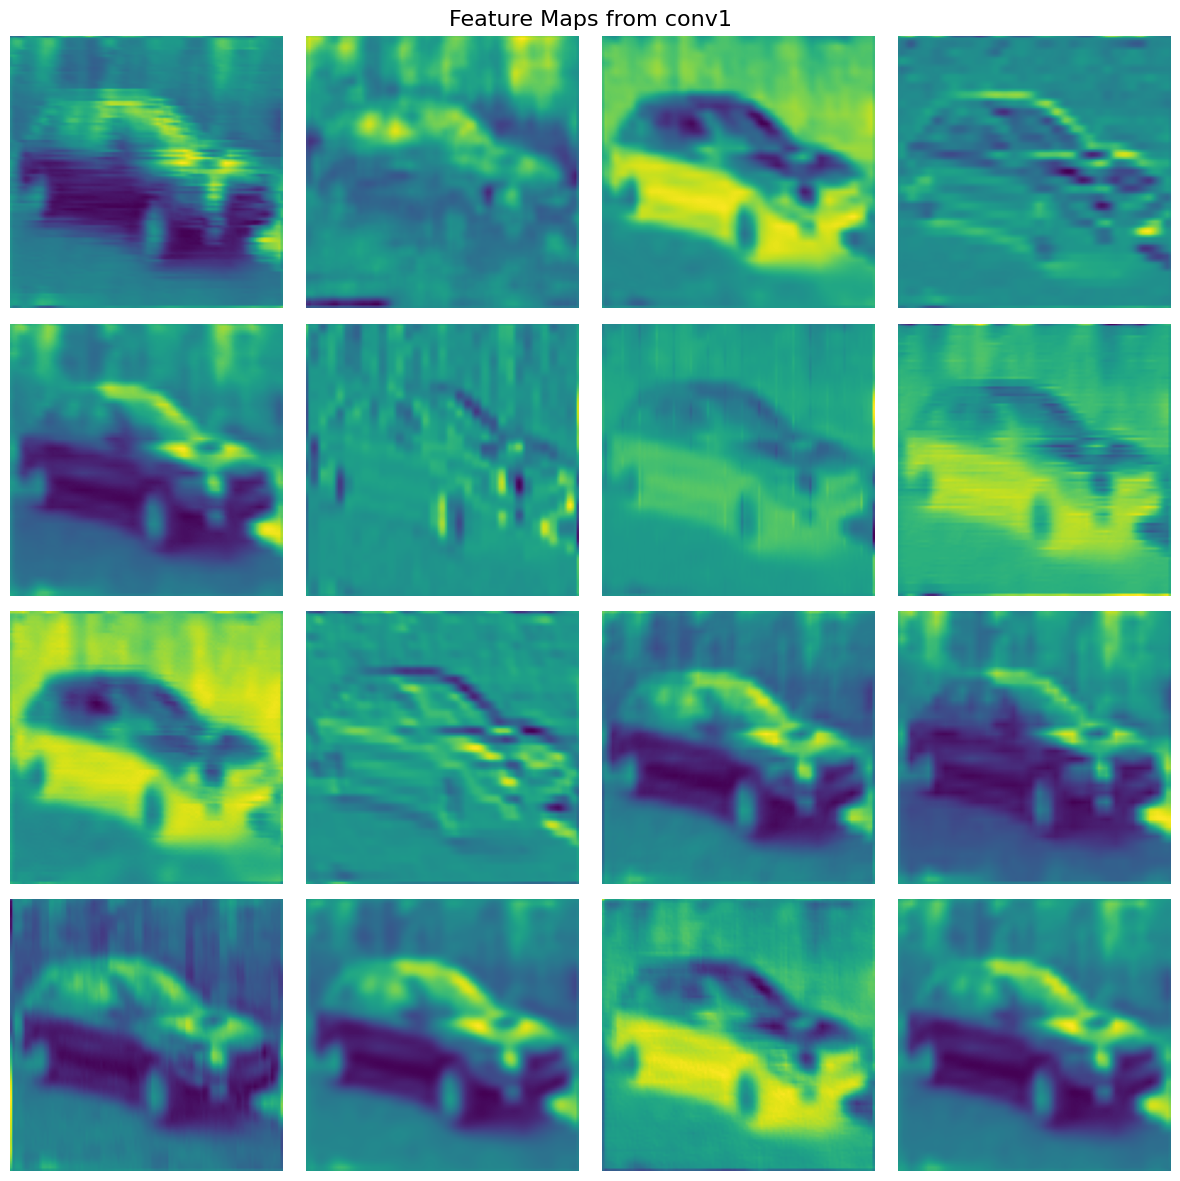

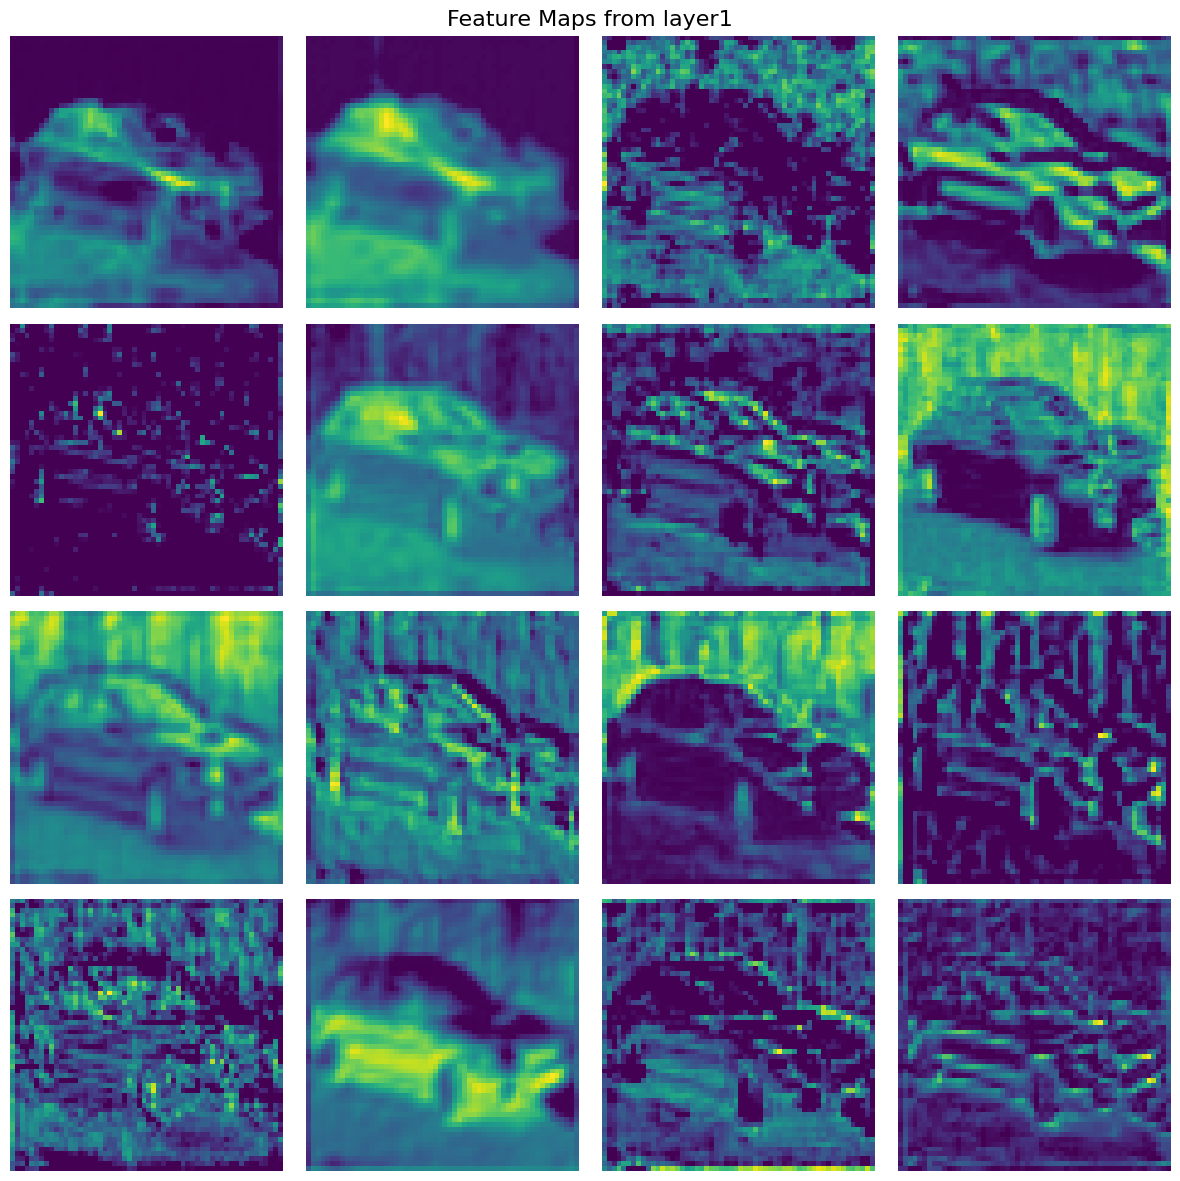

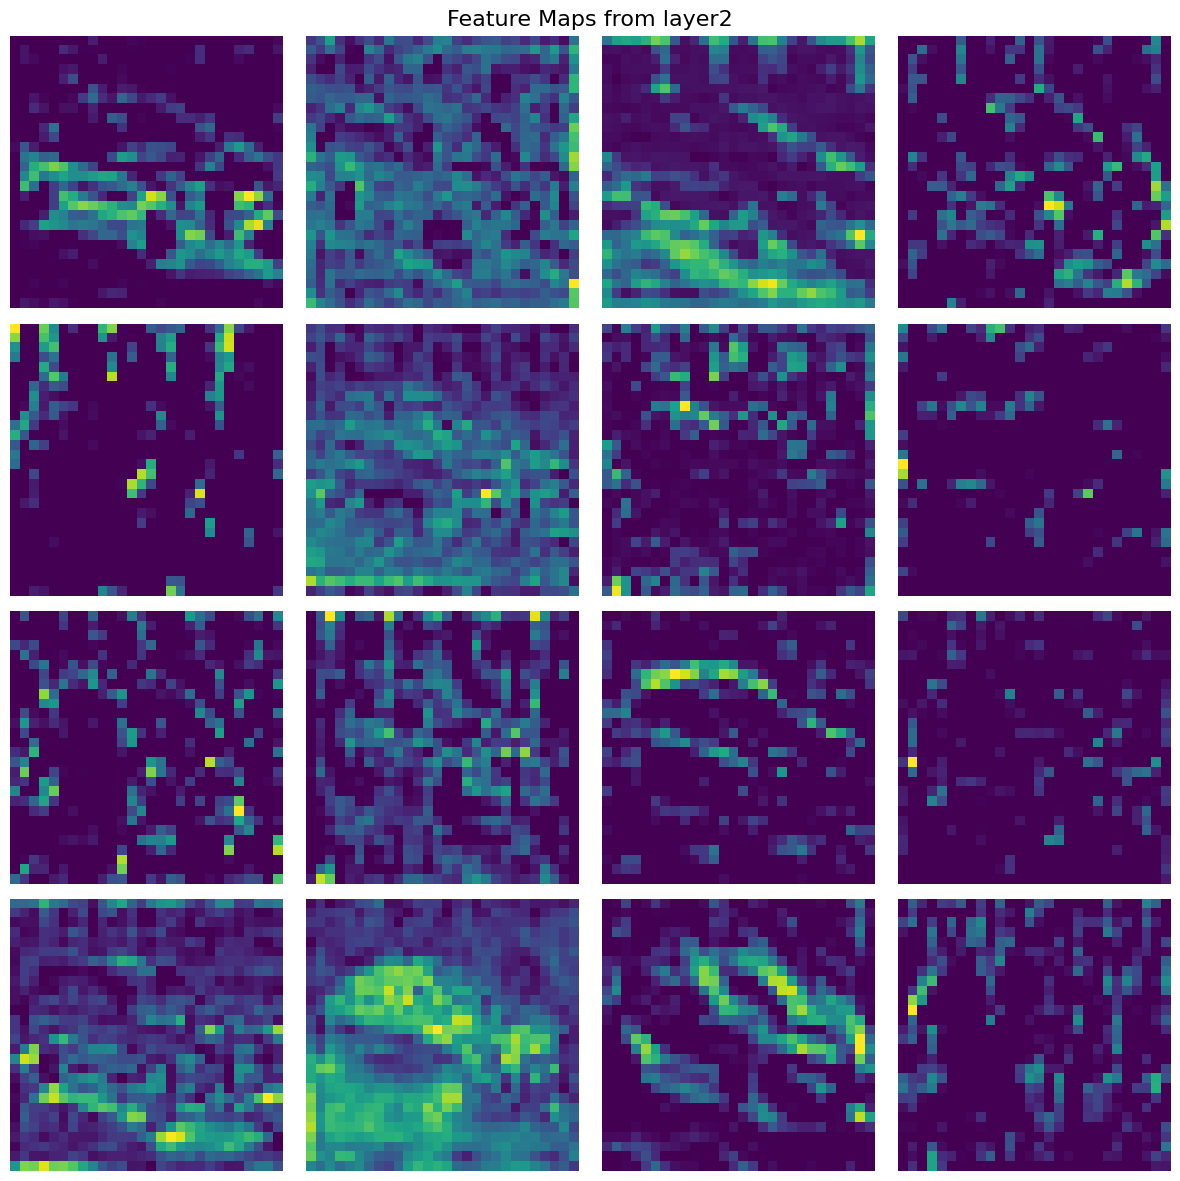

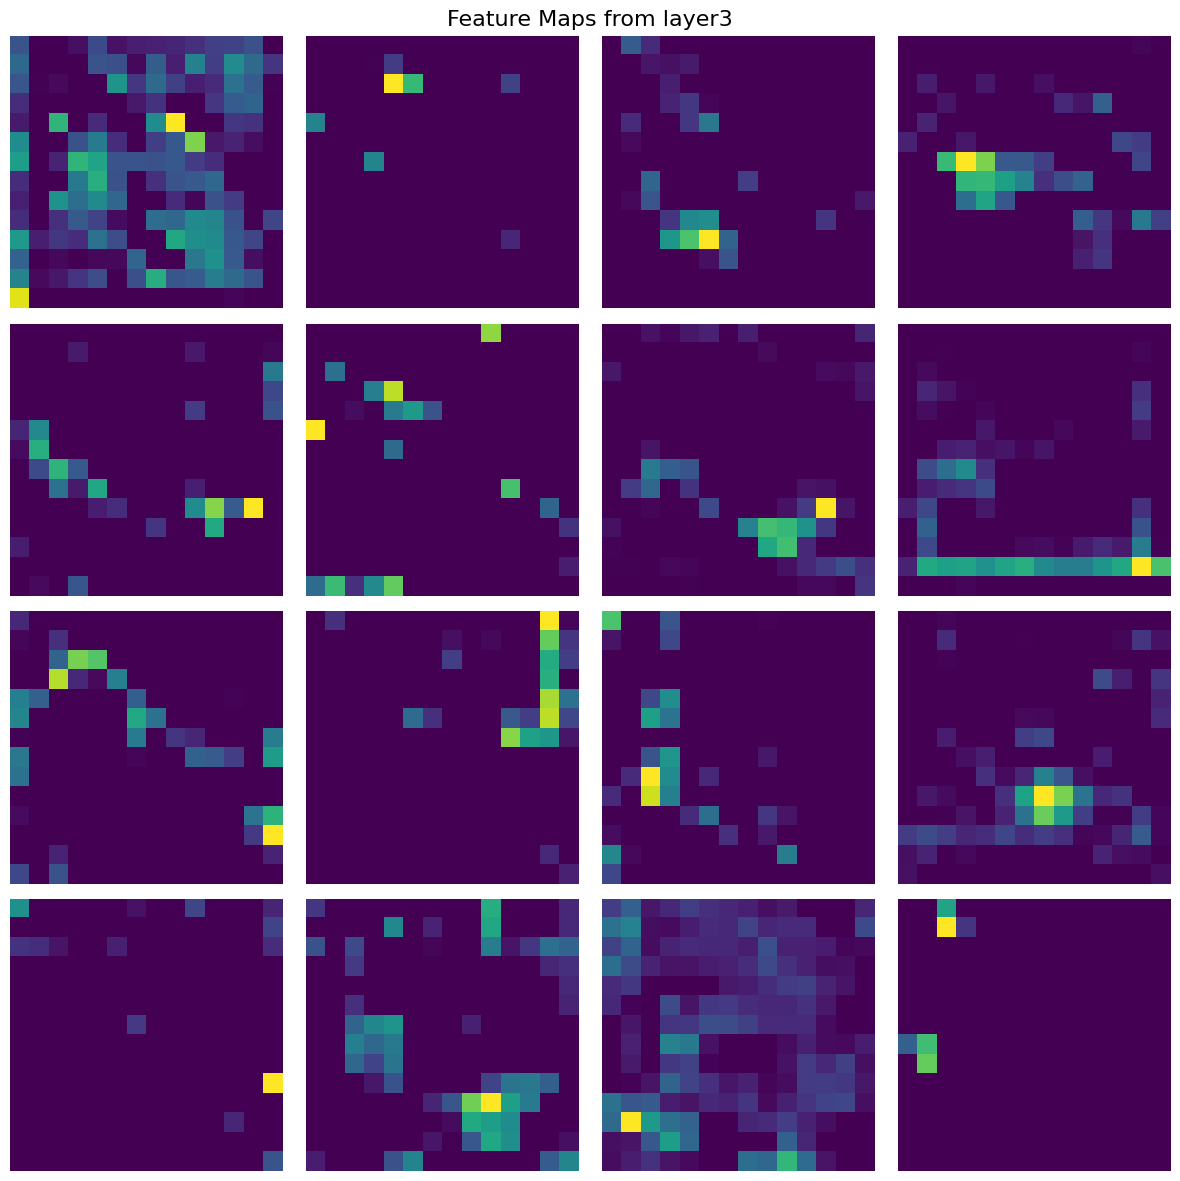

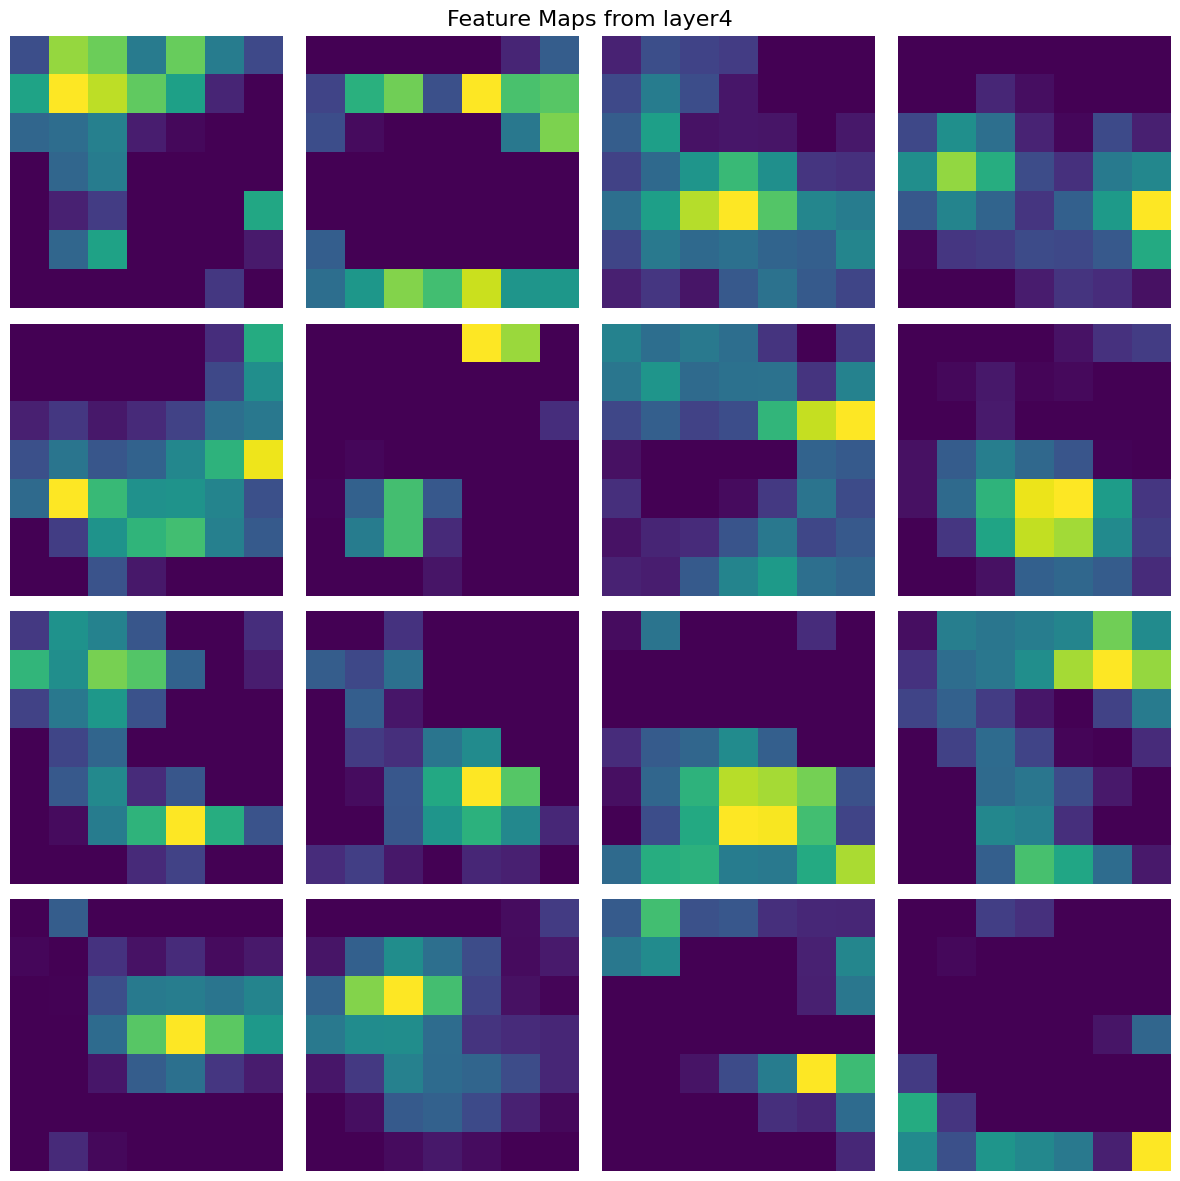

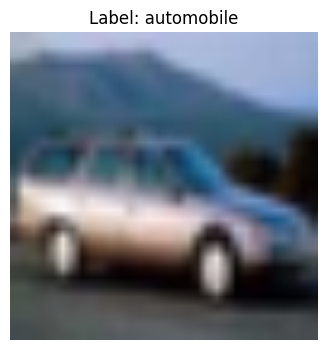

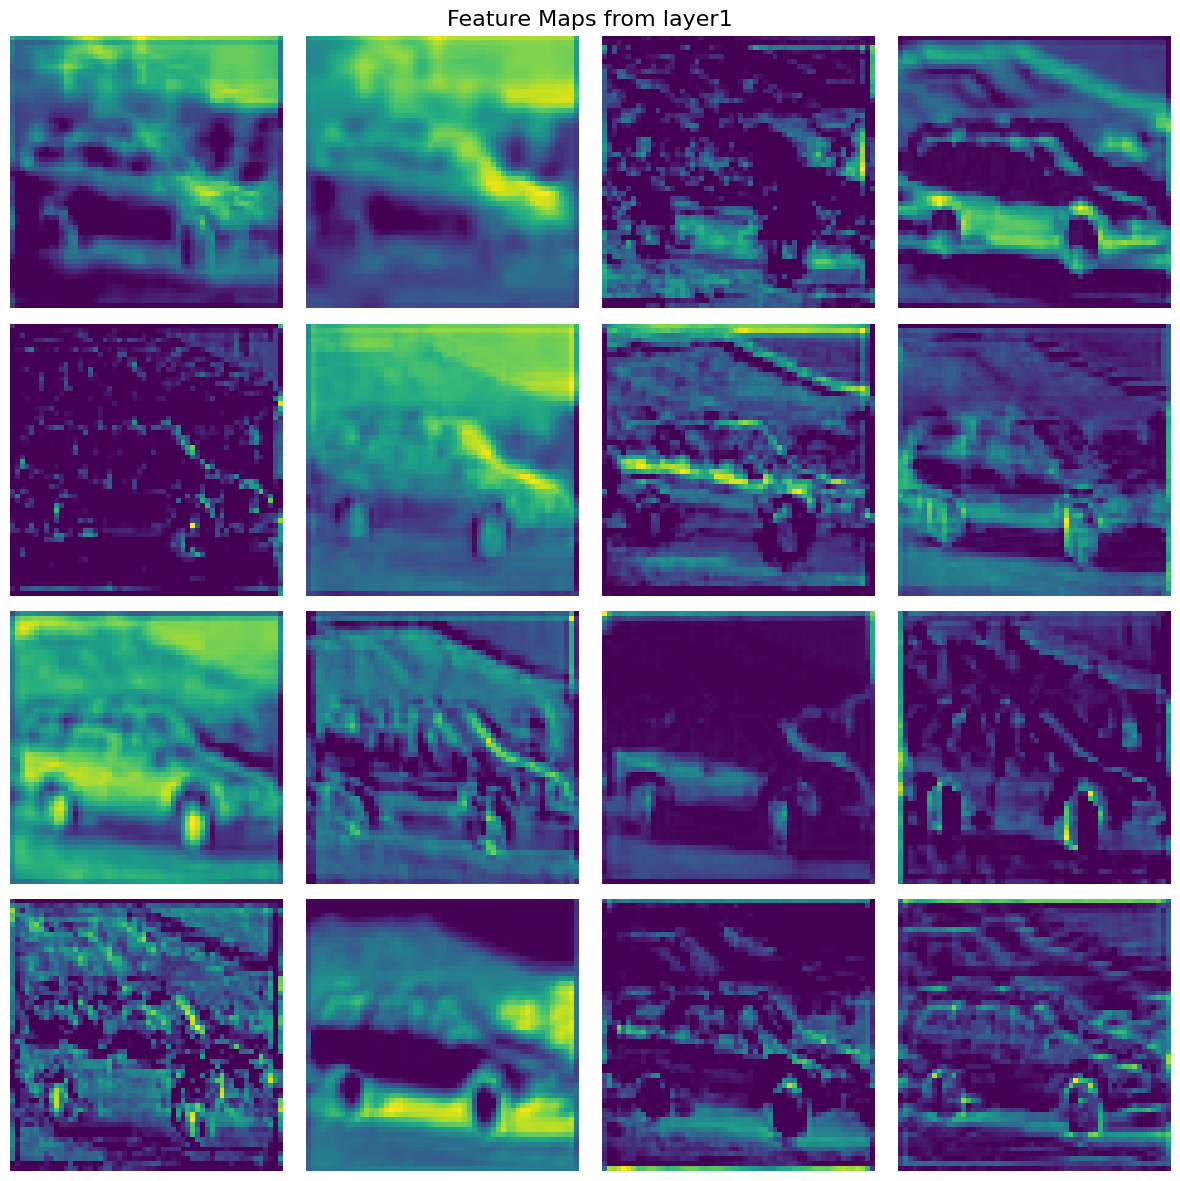

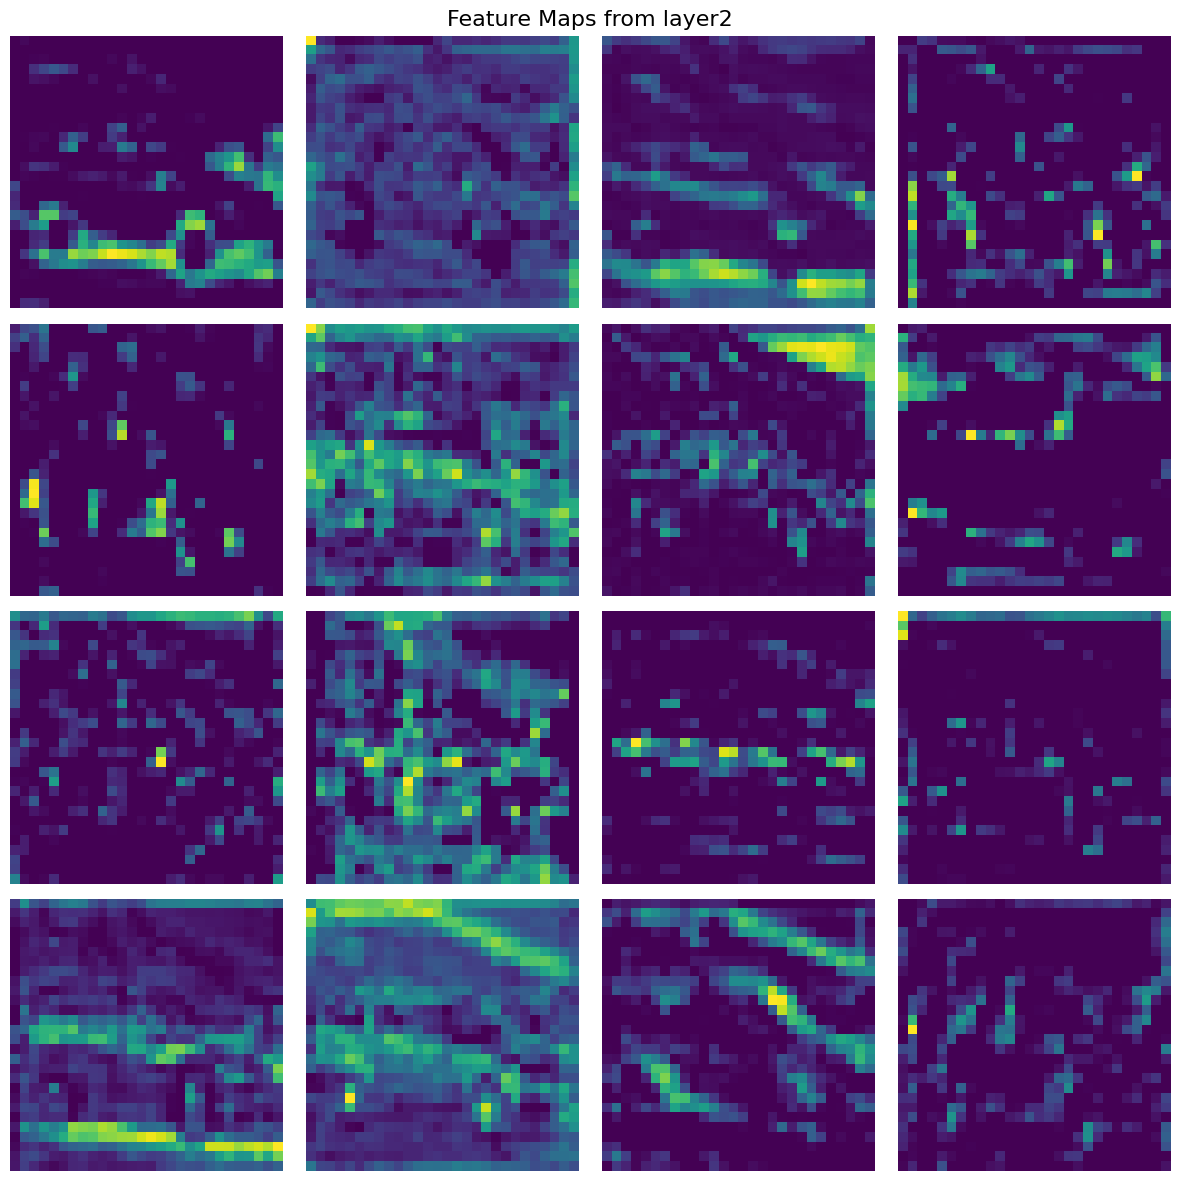

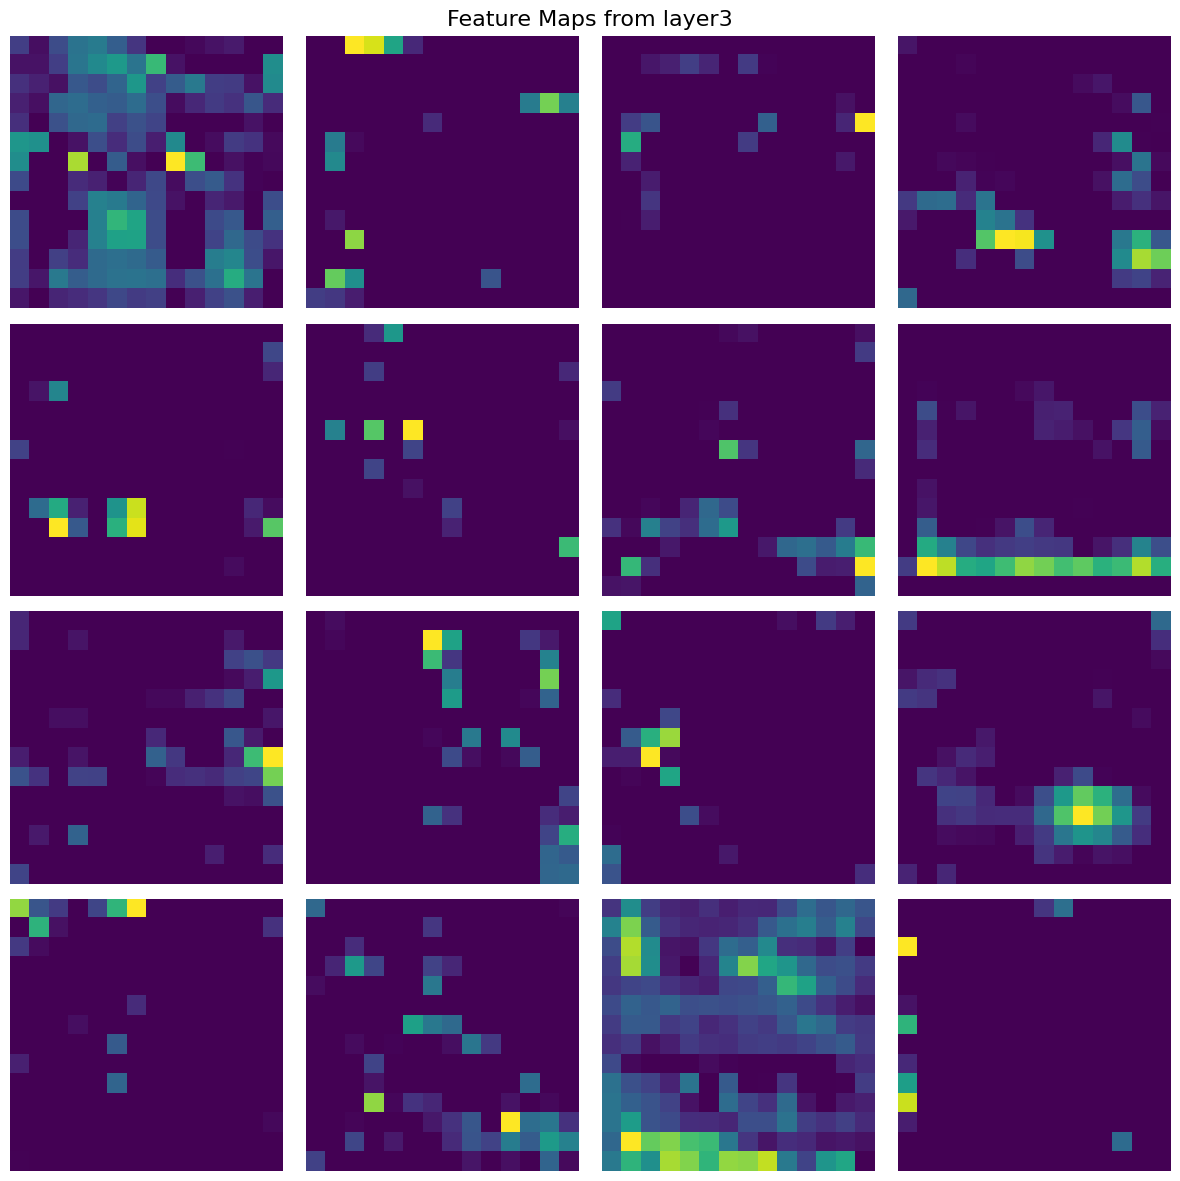

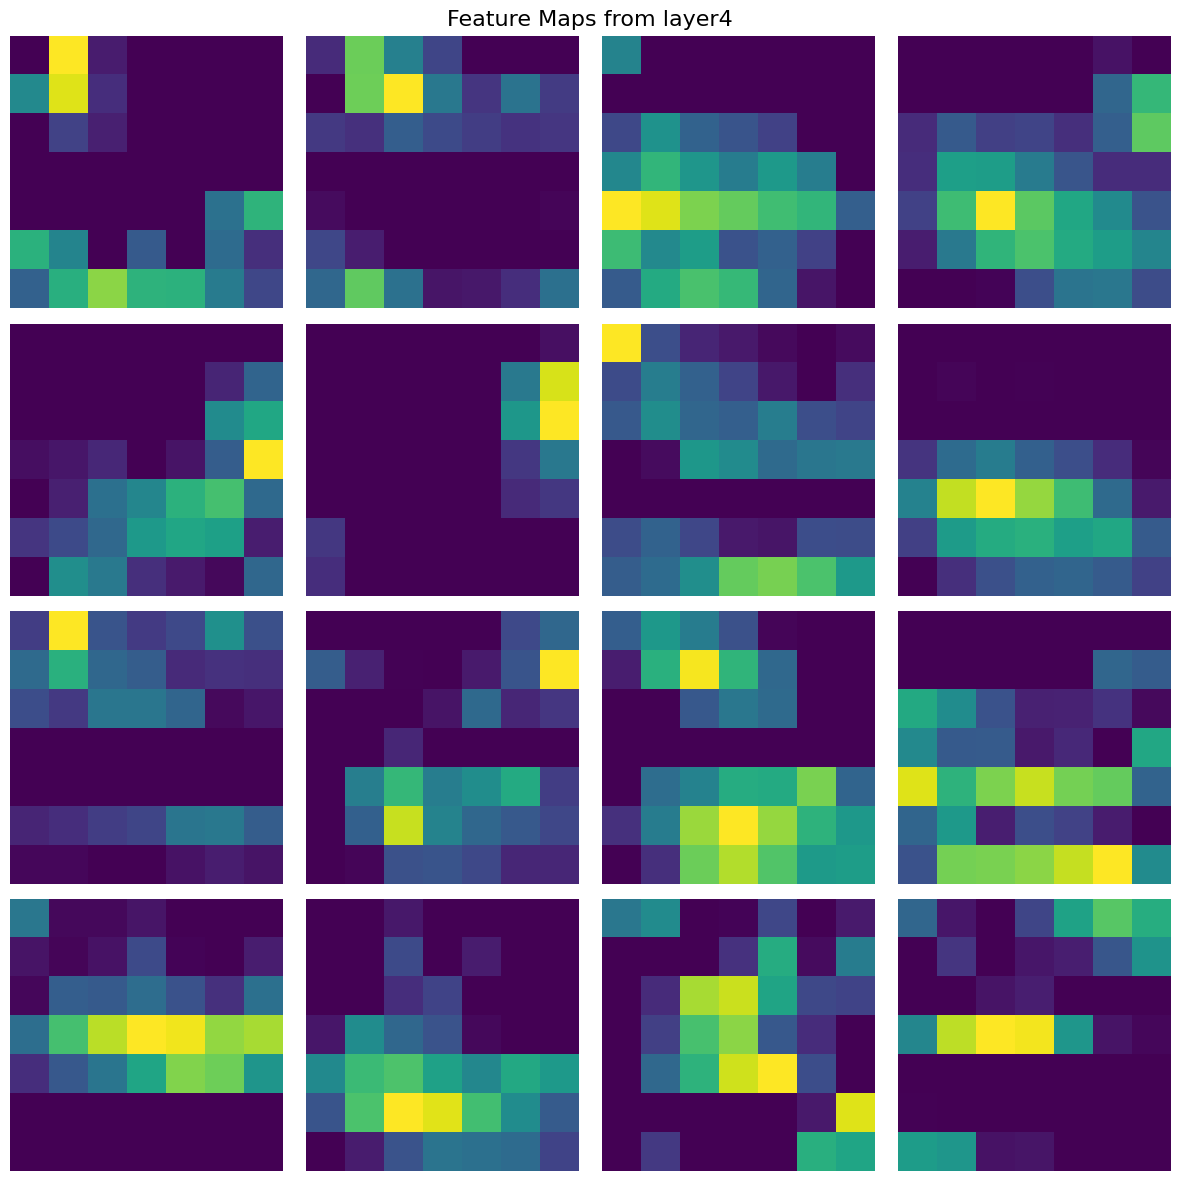

In [3]:
# -------------------------------
# Visualize Feature Maps
# -------------------------------
activation = {}

def get_activation(name):
    """Returns a hook function to capture activations."""
    def hook(model, input, output):
        activation[name] = output.detach().cpu()  # Detach and move to CPU
    return hook

def visualize_feature_maps(activation, layer_name, num_feature_maps=16):
    """Visualizes feature maps from a specified layer."""
    fmap = activation[layer_name]
    num_feature = fmap.shape[1]
    
    # Determine grid size based on the number of feature maps to display
    grid_size = int(np.ceil(np.sqrt(min(num_feature, num_feature_maps))))
    
    plt.figure(figsize=(12, 12))
    plt.suptitle(f'Feature Maps from {layer_name}', fontsize=16)
    
    for i in range(min(num_feature, num_feature_maps)):
        plt.subplot(grid_size, grid_size, i + 1)
        feature_map = fmap[0, i, :, :].numpy()  # Convert tensor to NumPy array
        plt.imshow(feature_map, cmap='viridis')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Register hooks to the desired layers
model_classifier.feature_extractor.conv1.register_forward_hook(get_activation('conv1'))
model_classifier.feature_extractor.layer1.register_forward_hook(get_activation('layer1'))
model_classifier.feature_extractor.layer2.register_forward_hook(get_activation('layer2'))
model_classifier.feature_extractor.layer3.register_forward_hook(get_activation('layer3'))
model_classifier.feature_extractor.layer4.register_forward_hook(get_activation('layer4'))

# Function to visualize feature maps after forward pass
def visualize_all_feature_maps(model, dataloader, class_names, layers_to_visualize=['conv1', 'layer1', 'layer2', 'layer3', 'layer4']):
    """
    Visualizes feature maps from specified layers using a batch of data.

    Args:
        model: The trained classifier model.
        dataloader: DataLoader for training data.
        class_names: List of class names.
        layers_to_visualize: List of layer names to visualize.
    """
    # Get a batch of training data
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    inputs = images.to(device)

    # Forward pass through the model
    output = model(inputs)

    # Plot feature maps for the first image in the batch
    for layer in layers_to_visualize:
        if layer in activation:
            visualize_feature_maps(activation, layer)

# Visualize feature maps using a batch from the training loader
visualize_all_feature_maps(model_classifier, train_loader, class_names)

# -------------------------------
# Visualize a Sample Image and Its Feature Maps
# -------------------------------
# Select a sample image from the training set
sample_idx = 0  # Change this index to visualize different images
sample_img, sample_label = train_dataset_full[sample_idx]

# Display the sample image
imshow(sample_img, f'Label: {class_names[sample_label]}')

# Visualize feature maps for the sample image
def visualize_sample_feature_maps(model, sample_image, layers_to_visualize=['layer1', 'layer2', 'layer3', 'layer4']):
    """
    Visualizes feature maps for a single sample image.

    Args:
        model: The trained classifier model.
        sample_image: A single input image tensor.
        layers_to_visualize: List of layer names to visualize.
    """
    # Reset activation dictionary
    global activation
    activation = {}

    # Register hooks to the specified layers
    hooks = []
    for name, layer in model.feature_extractor.named_modules():
        if name in layers_to_visualize:
            hooks.append(layer.register_forward_hook(get_activation(name)))

    # Forward pass
    input_image = sample_image.unsqueeze(0).to(device)  # Add batch dimension
    output = model(input_image)

    # Remove hooks
    for hook in hooks:
        hook.remove()

    # Plot feature maps
    for layer in layers_to_visualize:
        if layer in activation:
            visualize_feature_maps(activation, layer)

# Visualize feature maps for the selected sample image
visualize_sample_feature_maps(model_classifier, sample_img, layers_to_visualize=['layer1', 'layer2', 'layer3', 'layer4'])

# Analysis of Loss Functions for CNN Training on CIFAR-10

---

## **Part 1: Training with Cross Entropy Loss**

### 1. Pre-trained Neural Network and Training
- A **ResNet-50** pre-trained model was used as the feature extractor.
- The dataset was limited to two classes: **Car** (automobile) and **Airplane** from CIFAR-10.
- The network was trained with the **Cross Entropy Loss** to classify these two classes.

### 2. Accuracy and Loss for Each Epoch
- **Train Accuracy**: Increased from **91.10% (Epoch 1)** to **96.15% (Epoch 10)**.
- **Validation Accuracy**: Achieved a peak of **96.20% (Epoch 9)**, demonstrating good generalization.
- **Train Loss**: Gradually decreased to **0.0982** by the final epoch.
- **Validation Loss**: Reached a minimum of **0.0953**, indicating effective training.

### 3. Feature Map Analysis
- **Feature Maps for Car **:
  - Layer 1 Feature Maps highlight **coarse edges and textures**, crucial for differentiating between cars and airplanes.
  - Conv1 Feature Maps capture detailed edges, enabling the model to distinguish cars by focusing on distinct patterns like wheels and frames.
- The feature maps illustrate how **Cross Entropy Loss** enables effective extraction of class-specific features.

### 4. Conclusion for Cross Entropy Loss
- **Advantages**:
  - Achieved good accuracy (96.20%) with **fast convergence** (4 minutes of training).
  - Produced meaningful feature maps for distinguishing between classes.
- **Use Case**: Ideal for standard classification tasks where speed is a priority.

---

## **Part 2: Training with Triplet Loss**

### 1. Network and Training
- A custom network was used, where the **feature extractor** learns embeddings (features) optimized for the **Triplet Loss**.
- A fully connected layer was added to map the embeddings to class labels.

### 2. Accuracy and Loss for Each Epoch
- **Train Loss**: Decreased sharply from **0.1942 (Epoch 1)** to **0.0047 (Epoch 10)**, indicating rapid convergence.
- **Train Accuracy**: Reached **99.94%**, showcasing the model's capability to separate classes effectively in the embedding space.
- **Validation Accuracy**: Achieved a very high score of **99.75%**, indicating excellent generalization.

### 3. Feature Map Analysis
- **Feature Maps for Airplane**:
  - The maps emphasize **fine-grained details** in airplane structures, such as wings and fuselage.
  - **Triplet Loss** focuses on generating well-separated embeddings, allowing positive and negative samples to occupy distinct regions in the embedding space.

### 4. Conclusion for Triplet Loss
- **Advantages**:
  - Significantly higher accuracy (99.75%) compared to Cross Entropy Loss.
  - Robust embeddings that allow for excellent generalization.
- **Disadvantages**:
  - Computational complexity led to longer training time (**27 minutes**).
- **Use Case**: Best suited for tasks requiring **discriminative embeddings**, such as face recognition or content retrieval.

---

## **Part 3: Comparison and Conclusion**

### 1. Feature Map Quality
- **Cross Entropy Loss**:
  - Extracted class-specific features effectively, focusing on **categorical separation**.
- **Triplet Loss**:
  - Produced tightly clustered and **well-separated embeddings**, ideal for discriminative tasks.

### 2. Final Test Accuracy
| **Metric**           | **Cross Entropy Loss** | **Triplet Loss** |
|-----------------------|------------------------|------------------|
| Final Test Accuracy   | 96.20%                | 99.75%           |
| Training Time         | 4 minutes             | 27 minutes       |

### 3. Convergence Speed
- **Cross Entropy Loss**: Faster convergence due to its simplicity.
- **Triplet Loss**: Moderate convergence due to its computational complexity.

### 4. Conclusion
- **Cross Entropy Loss**:
  - Suitable for **fast classification tasks**.
- **Triplet Loss**:
  - Suitable for **retrieval-based or embedding-focused applications** where precision is critical.




Using device: cuda:0
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10
----------
Triplet Loss: 0.3375 Class Loss: 0.2139 Acc: 0.9189
Validation Loss: 0.0993 Validation Acc: 0.9610

Epoch 2/10
----------
Triplet Loss: 0.1141 Class Loss: 0.0901 Acc: 0.9682
Validation Loss: 0.0585 Validation Acc: 0.9830

Epoch 3/10
----------
Triplet Loss: 0.0683 Class Loss: 0.0602 Acc: 0.9776
Validation Loss: 0.0991 Validation Acc: 0.9640

Epoch 4/10
----------
Triplet Loss: 0.0387 Class Loss: 0.0473 Acc: 0.9841
Validation Loss: 0.0693 Validation Acc: 0.9765

Epoch 5/10
----------
Triplet Loss: 0.0387 Class Loss: 0.0511 Acc: 0.9820
Validation Loss: 0.0345 Validation Acc: 0.9870

Epoch 6/10
----------
Triplet Loss: 0.0251 Class Loss: 0.0428 Acc: 0.9849
Validation Loss: 0.0618 Validation Acc: 0.9755

Epoch 7/10
----------
Triplet Loss: 0.0328 Class Loss: 0.0411 Acc: 0.9833
Validation Loss: 0.0493 Validation Acc: 0.9850

Epoch 8/10
----------
Triplet Loss: 0.0101 Class 

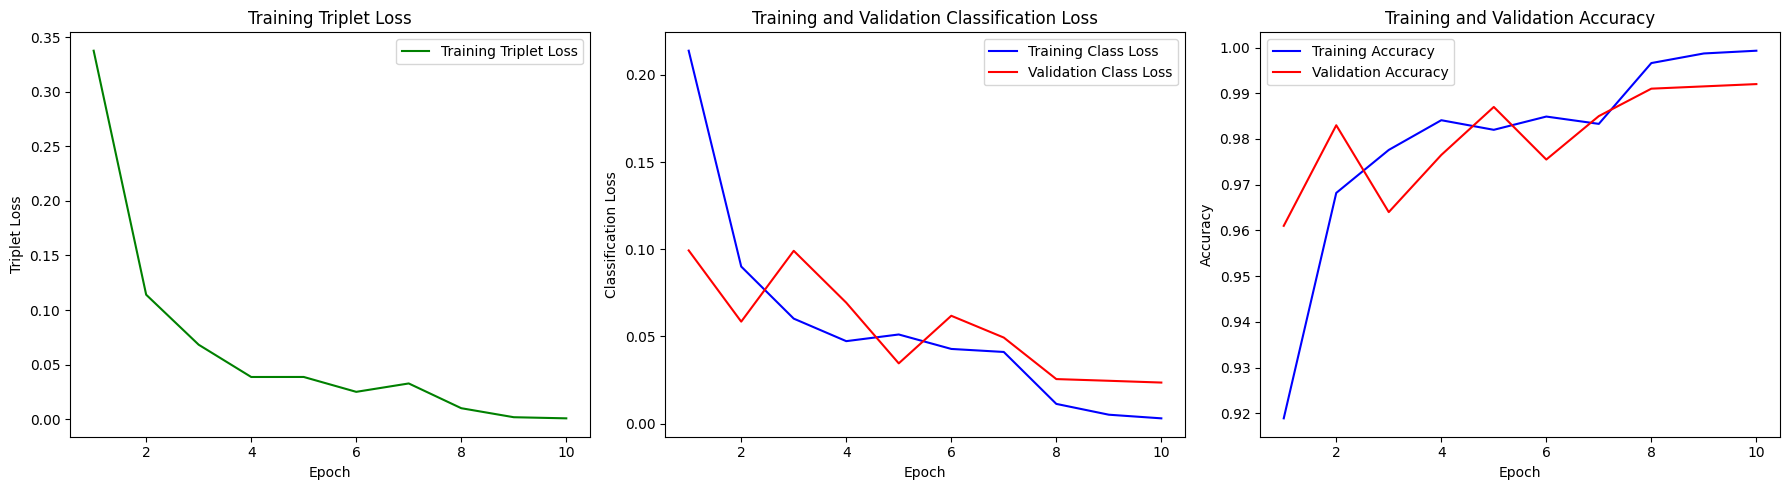

Test Accuracy: 0.9920

--- Analysis ---
Final Test Accuracy: 0.9920


In [4]:
# ----------------------------------------------
# CIFAR-10 Binary Classifier: Airplane vs. Automobile with Combined Loss Functions
# ----------------------------------------------

# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import time
import copy
import os
import random

# Set random seeds for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed()

# -------------------------------
# Device Configuration
# -------------------------------
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# -------------------------------
# Data Transformations
# -------------------------------
transform = transforms.Compose([
    transforms.Resize(224),  # ResNet-50 expects 224x224 images
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # Mean for normalization
                         [0.229, 0.224, 0.225])  # Std for normalization
])

# -------------------------------
# Download and Load CIFAR-10 Dataset
# -------------------------------
data_dir = './data'

train_dataset_full = datasets.CIFAR10(root=data_dir, train=True,
                                     download=True, transform=transform)
test_dataset_full = datasets.CIFAR10(root=data_dir, train=False,
                                    download=True, transform=transform)

# -------------------------------
# Filter Dataset for Classes 'Airplane' and 'Automobile'
# -------------------------------
def filter_classes(dataset, classes=[0, 1]):
    """
    Filters the dataset to include only specified classes.

    Args:
        dataset: The dataset to filter.
        classes: List of class indices to include.

    Returns:
        Filtered dataset.
    """
    mask = np.isin(dataset.targets, classes)
    dataset.data = dataset.data[mask]
    dataset.targets = np.array(dataset.targets)[mask]
    return dataset

# Apply the filter to both training and test datasets
train_dataset_full = filter_classes(train_dataset_full, classes=[0, 1])
test_dataset_full = filter_classes(test_dataset_full, classes=[0, 1])

# Convert targets to torch tensors
train_dataset_full.targets = torch.tensor(train_dataset_full.targets)
test_dataset_full.targets = torch.tensor(test_dataset_full.targets)

# Define class names
class_names = ['airplane', 'automobile']

# -------------------------------
# Triplet Dataset Class
# -------------------------------
class TripletCIFAR10(Dataset):
    def __init__(self, dataset, classes_to_include, transform=None):
        self.transform = transform
        self.classes_to_include = classes_to_include

        # Prepare data and targets
        self.data = []
        self.targets = []

        for idx in range(len(dataset)):
            img, label = dataset.data[idx], dataset.targets[idx].item()
            if label in classes_to_include:
                self.data.append(img)
                self.targets.append(classes_to_include.index(label))  # Remap labels to 0 and 1

        self.data = np.array(self.data)
        self.targets = np.array(self.targets)

        # Build a dictionary to map labels to indices
        self.label_to_indices = {label: np.where(self.targets == label)[0]
                                 for label in set(self.targets)}

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        anchor_img = self.data[idx]
        anchor_label = self.targets[idx]

        # Select a positive sample
        positive_idx = idx
        while positive_idx == idx:
            positive_idx = np.random.choice(self.label_to_indices[anchor_label])
        positive_img = self.data[positive_idx]

        # Select a negative sample
        negative_label = (anchor_label + 1) % 2  # Since we have only 2 classes
        negative_idx = np.random.choice(self.label_to_indices[negative_label])
        negative_img = self.data[negative_idx]

        # Transform images
        anchor_img = Image.fromarray(anchor_img)
        positive_img = Image.fromarray(positive_img)
        negative_img = Image.fromarray(negative_img)

        if self.transform:
            anchor_img = self.transform(anchor_img)
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)

        return (anchor_img, positive_img, negative_img), []

# -------------------------------
# Create Triplet Dataset and DataLoader
# -------------------------------
batch_size_triplet = 32

train_dataset_triplet = TripletCIFAR10(train_dataset_full, classes_to_include=[0, 1], transform=transform)
train_loader_triplet = DataLoader(train_dataset_triplet, batch_size=batch_size_triplet, shuffle=True, num_workers=2)

# -------------------------------
# Combined Model Definition
# -------------------------------
class ResNet50Combined(nn.Module):
    def __init__(self, pretrained=True, embedding_dim=512, num_classes=2):
        super(ResNet50Combined, self).__init__()
        self.backbone = models.resnet50(pretrained=pretrained)
        num_ftrs = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()  # Remove the final classification layer

        # Embedding layer
        self.embedding = nn.Linear(num_ftrs, embedding_dim)

        # Classification layer
        self.classifier = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        features = self.backbone(x)
        embeddings = self.embedding(features)
        logits = self.classifier(embeddings)
        return embeddings, logits

# Instantiate the combined model
model_combined = ResNet50Combined(pretrained=True, embedding_dim=512, num_classes=2)
model_combined = model_combined.to(device)

# -------------------------------
# Define Loss Criterion and Optimizer for Combined Model
# -------------------------------
# Define triplet loss and cross-entropy loss
triplet_criterion = nn.TripletMarginLoss(margin=1.0, p=2)
classification_criterion = nn.CrossEntropyLoss()

# Define optimizer to update all parameters
optimizer_combined = optim.Adam(model_combined.parameters(), lr=0.001)

# Define a learning rate scheduler (optional)
scheduler_combined = lr_scheduler.StepLR(optimizer_combined, step_size=7, gamma=0.1)

# -------------------------------
# Training and Validation Datasets and DataLoaders
# -------------------------------
# For classification, use standard DataLoader
train_loader_class = DataLoader(train_dataset_full, batch_size=32, shuffle=True, num_workers=2)
test_loader_class = DataLoader(test_dataset_full, batch_size=32, shuffle=False, num_workers=2)

# -------------------------------
# Training Loop for Combined Model
# -------------------------------
def train_combined_model(model, triplet_loader, classification_train_loader, classification_val_loader,
                        triplet_criterion, classification_criterion, optimizer, scheduler, num_epochs=10):
    """
    Trains the combined model using both triplet loss and cross-entropy loss.

    Args:
        model: The combined neural network model.
        triplet_loader: DataLoader for triplet data.
        classification_train_loader: DataLoader for classification training data.
        classification_val_loader: DataLoader for classification validation data.
        triplet_criterion: Triplet loss function.
        classification_criterion: Cross-entropy loss function.
        optimizer: Optimization algorithm.
        scheduler: Learning rate scheduler.
        num_epochs: Number of epochs to train.

    Returns:
        Trained model and training history.
    """
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Lists to store loss and accuracy
    train_triplet_losses = []
    train_class_losses = []
    val_class_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Set model to training mode
        model.train()

        running_triplet_loss = 0.0
        running_class_loss = 0.0
        running_corrects = 0
        total = 0

        # Create iterators for loaders
        triplet_iter = iter(triplet_loader)
        class_iter = iter(classification_train_loader)

        # Determine number of batches
        num_batches = max(len(triplet_loader), len(classification_train_loader))

        for _ in range(num_batches):
            # Get triplet batch
            try:
                (anchor, positive, negative), _ = next(triplet_iter)
            except StopIteration:
                triplet_iter = iter(triplet_loader)
                (anchor, positive, negative), _ = next(triplet_iter)

            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)

            # Get classification batch
            try:
                inputs_class, labels_class = next(class_iter)
            except StopIteration:
                class_iter = iter(classification_train_loader)
                inputs_class, labels_class = next(class_iter)

            inputs_class = inputs_class.to(device)
            labels_class = labels_class.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass for triplet loss
            embeddings_anchor, _ = model(anchor)
            embeddings_positive, _ = model(positive)
            embeddings_negative, _ = model(negative)

            triplet_loss = triplet_criterion(embeddings_anchor, embeddings_positive, embeddings_negative)

            # Forward pass for classification loss
            _, logits = model(inputs_class)
            class_loss = classification_criterion(logits, labels_class)

            # Total loss
            total_loss = triplet_loss + class_loss

            # Backward pass and optimize
            total_loss.backward()
            optimizer.step()

            # Statistics for triplet loss
            running_triplet_loss += triplet_loss.item() * anchor.size(0)

            # Statistics for classification loss
            running_class_loss += class_loss.item() * inputs_class.size(0)

            # Statistics for accuracy
            _, preds = torch.max(logits, 1)
            running_corrects += torch.sum(preds == labels_class.data)
            total += labels_class.size(0)

        # Step the scheduler
        scheduler.step()

        epoch_triplet_loss = running_triplet_loss / len(triplet_loader.dataset)
        epoch_class_loss = running_class_loss / len(classification_train_loader.dataset)
        epoch_acc = running_corrects.double() / total

        train_triplet_losses.append(epoch_triplet_loss)
        train_class_losses.append(epoch_class_loss)
        train_accuracies.append(epoch_acc.item())

        print(f'Triplet Loss: {epoch_triplet_loss:.4f} Class Loss: {epoch_class_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        running_val_corrects = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in classification_val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                _, logits = model(inputs)
                loss = classification_criterion(logits, labels)

                running_val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(logits, 1)
                running_val_corrects += torch.sum(preds == labels.data)
                val_total += labels.size(0)

        epoch_val_loss = running_val_loss / len(classification_val_loader.dataset)
        epoch_val_acc = running_val_corrects.double() / val_total

        val_class_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc.item())

        print(f'Validation Loss: {epoch_val_loss:.4f} Validation Acc: {epoch_val_acc:.4f}')

        # Deep copy the model if it has better accuracy
        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Combined Training complete in {int(time_elapsed // 60)}m {int(time_elapsed % 60)}s')
    print(f'Best Validation Accuracy: {best_acc:.4f}')

    # Load the best model weights
    model.load_state_dict(best_model_wts)

    history = {
        'train_triplet_loss': train_triplet_losses,
        'train_class_loss': train_class_losses,
        'val_class_loss': val_class_losses,
        'train_acc': train_accuracies,
        'val_acc': val_accuracies
    }

    return model, history

# -------------------------------
# Train the Combined Model
# -------------------------------
num_epochs_combined = 10  # You can adjust the number of epochs

model_combined, history_combined = train_combined_model(
    model_combined,
    triplet_loader=train_loader_triplet,
    classification_train_loader=train_loader_class,
    classification_val_loader=test_loader_class,
    triplet_criterion=triplet_criterion,
    classification_criterion=classification_criterion,
    optimizer=optimizer_combined,
    scheduler=scheduler_combined,
    num_epochs=num_epochs_combined
)

# -------------------------------
# Plotting Training Histories
# -------------------------------
def plot_combined_history(history, num_epochs):
    """
    Plots the training and validation loss and accuracy.

    Args:
        history: Dictionary containing loss and accuracy history.
        num_epochs: Number of epochs.
    """
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(18, 5))

    # Plot Triplet Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['train_triplet_loss'], 'g-', label='Training Triplet Loss')
    plt.title('Training Triplet Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Triplet Loss')
    plt.legend()

    # Plot Classification Loss
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['train_class_loss'], 'b-', label='Training Class Loss')
    plt.plot(epochs, history['val_class_loss'], 'r-', label='Validation Class Loss')
    plt.title('Training and Validation Classification Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Classification Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the combined training history
plot_combined_history(history_combined, num_epochs_combined)

# -------------------------------
# Evaluate the Combined Model on the Test Set
# -------------------------------
def evaluate_combined_model(model, dataloader):
    """
    Evaluates the model on the test set.

    Args:
        model: The trained combined model.
        dataloader: DataLoader for test data.

    Returns:
        Accuracy of the model on the test set.
    """
    model.eval()
    running_corrects = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            _, logits = model(inputs)
            _, preds = torch.max(logits, 1)

            running_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)

    accuracy = running_corrects.double() / total
    print('Test Accuracy: {:.4f}'.format(accuracy))
    return accuracy

# Calculate test accuracy
test_accuracy_combined = evaluate_combined_model(model_combined, test_loader_class)

# -------------------------------
# Analysis
# -------------------------------
print("\n--- Analysis ---")
print(f"Final Test Accuracy: {test_accuracy_combined:.4f}")


## **Part 4: Training with Hybrid Loss**

### 1. End-to-End Training with Combined Loss
- The loss function was defined as:
  \[ L_{total} = L_{triplet} + L_{cross-entropy} \]
- The entire model (feature extractor and classifier) was trained **end-to-end**.

### 2. Accuracy and Loss for Each Epoch
- **Train Accuracy**: Improved from **91.89% (Epoch 1)** to **99.93% (Epoch 10)**.
- **Validation Accuracy**: Achieved a peak of **99.20%** by Epoch 10.
- **Train Loss**: A combination of **Triplet Loss** and **Cross Entropy Loss**, decreased consistently.

### 3. Feature Map Analysis
- Feature Maps from the hybrid loss combined:
  - **Cross Entropy Loss's strength** in extracting **class-specific features**.
  - **Triplet Loss's strength** in creating **discriminative embeddings**.

### 4. Conclusion for Hybrid Loss
- **Advantages**:
  - Achieved **high accuracy** (99.20%) with balanced feature representation.
  - Combines the generalization capability of Triplet Loss with the classification efficiency of Cross Entropy Loss.
- **Disadvantages**:
  - Training time was longer (**39 minutes**).
- **Use Case**: Suitable for tasks requiring both high-quality embeddings and accurate classification.

---

## **Overall Conclusion**

### Summary of Loss Functions
1. **Cross Entropy Loss**:
   - Fast, efficient, and ideal for standard classification tasks.
   - Limitations: Does not produce highly discriminative embeddings.

2. **Triplet Loss**:
   - Produces robust embeddings and excels in discriminative tasks.
   - Limitations: Computationally expensive and slower training.

3. **Hybrid Loss**:
   - Balances the strengths of both losses.
   - Provides robust embeddings and accurate classification.

### Recommendations
- Use **Cross Entropy Loss** for **quick classification tasks**.
- Use **Triplet Loss** or **Hybrid Loss** for applications requiring **retrieval, face recognition, or embedding robustness**.